# Inverse Design of a Directional Coupler (2D) with minimax and lengthscale constraints

In [1]:
import meep as mp
print(mp.__version__)
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa, tensor_jacobian_product, grad

from matplotlib import pyplot as plt
from matplotlib.patches import Circle

import nlopt
from IPython.display import Video
from typing import NamedTuple


1.27.0


In [2]:
seed = np.random.randint(100000)
np.random.seed(seed)
mp.verbosity(0)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

minimum_length = 0.15 # (μm)
eta_e = 0.75
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length,eta_e) # (μm)

waveguide_width = 0.5 # (μm)
design_region_length = 7 + (4 * filter_radius) # (μm)
design_region_width = 4 + (4 * filter_radius)  # (μm)


arm_separation = 3.5 #design_region_width - waveguide_width - 4 * filter_radius  # (μm) distance between arms center to center
waveguide_length = 2 # (μm)
pml_size = 1.0 # (μm)
resolution = 20 # (pixels/μm)

In [3]:
#filter_radius=minimum_length

eta_i = 0.5
eta_d = 1-eta_e
design_region_resolution = int(resolution) # (pixels/μm)
nf=50
frequencies = 1/np.linspace(1.5,1.6,nf) # (1/μm)

Nx = int(design_region_resolution*design_region_length)+1
Ny = int(design_region_resolution*design_region_width)+1


In [4]:
Sx = 2*pml_size + waveguide_length/2 + design_region_length+1 # cell size in X
Sy = 2*pml_size + design_region_width + 2 # cell size in Y
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(pml_size)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen#1/1.5 - 1/1.6#width * fcen
#source_center  = [-Sx/2 + pml_size + waveguide_length/3,arm_separation/2,0]
source_size    = mp.Vector3(0,2,0)
kpoint = mp.Vector3(1,0,0)

source_center1  = [-Sx/2 + pml_size+0.2 ,arm_separation/2,0]
source_center2  = [-Sx/2 + pml_size+0.2 ,-arm_separation/2,0]


# src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
# source = [mp.EigenModeSource(src,
#                     eig_band = 1,
#                     direction=mp.NO_DIRECTION,
#                     eig_kpoint=kpoint,
#                     size = source_size,
#                     center=source_center)]

x_g = np.linspace(
    -design_region_length / 2,
    design_region_length / 2,
    Nx,
)
y_g = np.linspace(
    -design_region_width / 2,
    design_region_width / 2,
    Ny,
)
X_g, Y_g = np.meshgrid(
    x_g,
    y_g,
    sparse=True,
    indexing="ij",
)

tl_wg_mask = (X_g <= -design_region_length / 2 + filter_radius) & (
    Y_g <= (arm_separation + waveguide_width) / 2) & ( Y_g  >=(arm_separation - waveguide_width) / 2
)
                                                      
tr_wg_mask = (X_g >= design_region_length / 2 - filter_radius) & (
    Y_g <= (arm_separation + waveguide_width) / 2) & ( Y_g  >=(arm_separation - waveguide_width) / 2
)

br_wg_mask = (X_g >= design_region_length / 2 - filter_radius) & (
    Y_g <= (-arm_separation + waveguide_width) / 2) & ( Y_g  >=(-arm_separation - waveguide_width) / 2
)
                                                       
bl_wg_mask = (X_g <= -design_region_length / 2 + filter_radius) & (
    Y_g <= (-arm_separation + waveguide_width) / 2) & ( Y_g  >=(-arm_separation - waveguide_width) / 2
)                                                      
                                                     

Si_mask = tl_wg_mask | tr_wg_mask | br_wg_mask | bl_wg_mask

border_mask = (
    (X_g <= -design_region_length / 2 + filter_radius)
    | (X_g >= design_region_length / 2 - filter_radius)
    | (Y_g <= -design_region_width / 2 + filter_radius)
    | (Y_g >= design_region_width / 2 - filter_radius)
)
Air_mask = border_mask.copy()
Air_mask[Si_mask] = False


In [5]:
evaluation_history = []
cur_iter = [0]
objfunc_history=[]
epivar_history=[]

def mapping(x: np.ndarray, eta: float, beta: float) -> np.ndarray:
    """A differentiable mapping function which applies, in order,
       the following sequence of transformations to the design weights:
       (1) a bit mask for the boundary pixels, (2) convolution with a
       conic filter, and (3) projection via a hyperbolic tangent (if
       necessary).

    Args:
      x: design weights as a 1d array of size Nx*Ny.
      eta: erosion/dilation parameter for the projection.
      beta: bias parameter for the projection. A value of 0 is no projection.

    Returns:
      The mapped design weights as a 1d array.
    """
    x = npa.where(Si_mask.flatten(), 1, npa.where(Air_mask.flatten(), 0, x.flatten()))

    x = (npa.fliplr(x.reshape(Nx,Ny)) + x.reshape(Nx,Ny))/2 # up-down symmetry
    x = (npa.flipud(x.reshape(Nx,Ny)) + x.reshape(Nx,Ny))/2 # left-right symmetry

    filtered_field = mpa.conic_filter(x, filter_radius,design_region_length,design_region_width,design_region_resolution)

    if beta == 0:
        return filtered_field.flatten()

    else:
        projected_field = mpa.tanh_projection(filtered_field,beta,eta)

        return projected_field.flatten()
    




def f(x, grad):
    t = x[0]  # "dummy" parameter
    v = x[1:]  # design parameters
    if grad.size > 0:
        grad[0] = 1
        grad[1:] = 0
    return t



def c(
    result: np.ndarray, 
    x: np.ndarray, 
    gradient: np.ndarray, 
    eta: float,
    beta: float, use_epsavg: bool):
    

    """Constraint function for the epigraph formulation.

    Args:
      result: the result of the function evaluation modified in place.
      x: 1d array of size 1+Nx*Ny containing epigraph variable (first
         element) and design weights (remaining Nx*Ny elements).
      gradient: the Jacobian matrix with dimensions (1+Nx*Ny,
                2*num. wavelengths) modified in place.
      eta: erosion/dilation parameter for projection.
      beta: bias parameter for projection.
      use_epsavg: whether to use subpixel smoothing.
    """

    print(
        "Current iteration: {}; current eta: {}, current beta: {}".format(
            cur_iter[0], eta, beta
        )
    )



    t = x[0]  # epigraph variable
    v = x[1:]  # design weights

    f0, dJ_du = opt([mapping(v, eta, 0 if use_epsavg else beta)])

    f0_reflection_top = f0[0]
    f0_reflection_bottom = f0[1]
    f0_transmission = f0[2]

    f0_merged = np.concatenate((f0_reflection_top,f0_reflection_bottom , f0_transmission))
    f0_merged_str = '[' + ','.join(str(ff) for ff in f0_merged) + ']'

    dJ_du_reflection_top = dJ_du[0]
    dJ_du_reflection_bottom = dJ_du[1]
    dJ_du_transmission = dJ_du[2]
     
    my_grad = np.zeros((Nx * Ny, 3 * nf))
    my_grad[:, :nf] = dJ_du_reflection_top
    my_grad[:, nf:2*nf] = dJ_du_reflection_bottom
    my_grad[:, 2*nf:] = dJ_du_transmission

    # backpropagate the gradients through mapping function
    for k in range(3 * nf):
        my_grad[:, k] = tensor_jacobian_product(mapping, 0)(
            v,
            eta,
            beta,
            my_grad[:, k],
        )

    if gradient.size > 0:
        gradient[:, 0] = -1  # gradient w.r.t. epigraph variable ("t")
        gradient[:, 1:] = my_grad.T  # gradient w.r.t. each frequency objective

    result[:] = np.real(f0_merged) - t

    objfunc_history.append(np.real(f0_merged))
    epivar_history.append(t)

    # visualize
    plt.figure()
    ax = plt.gca()
    opt.plot2D(
        False,
        ax=ax,
        plot_sources_flag=False,
        plot_monitors_flag=False,
        plot_boundaries_flag=False,
    )
    circ = Circle((2, 2), minimum_length / 2)
    ax.add_patch(circ)
    ax.axis("off")
    plt.show()

    cur_iter[0] = cur_iter[0] + 1



def glc(result: np.ndarray, x: np.ndarray, gradient: np.ndarray,
        beta: float) -> float:
    """Constraint function for the minimum linewidth.

    Args:
      result: the result of the function evaluation modified in place.
      x: 1d array of size 1+Nx*Ny containing epigraph variable (first
         element) and design weights (remaining elements).
      gradient: the Jacobian matrix with dimensions (1+Nx*Ny,
                num. wavelengths) modified in place.
      beta: bias parameter for projection.

    Returns:
      The value of the constraint function (a scalar).
    """
    t = x[0]  # dummy parameter
    v = x[1:]  # design parameters
    a1 = 1e-3  # hyper parameter (primary)
    b1 = 0  # hyper parameter (secondary)
    gradient[:, 0] = -a1

    filter_f = lambda a: mpa.conic_filter(
        a.reshape(Nx, Ny),
        filter_radius,
        design_region_length,
        design_region_width,
        design_region_resolution,
    )
    threshold_f = lambda a: mpa.tanh_projection(a, beta, eta_i)

    # hyper parameter (constant factor and exponent)
    c0 = 1e7 * (filter_radius * 1 / resolution) ** 4

    M1 = lambda a: mpa.constraint_solid(a, c0, eta_e, filter_f, threshold_f, 1)
    M2 = lambda a: mpa.constraint_void(a, c0, eta_d, filter_f, threshold_f, 1)

    g1 = grad(M1)(v)
    g2 = grad(M2)(v)

    result[0] = M1(v) - a1 * t - b1
    result[1] = M2(v) - a1 * t - b1

    gradient[0, 1:] = g1.flatten()
    gradient[1, 1:] = g2.flatten()

    t1 = (M1(v) - b1) / a1
    t2 = (M2(v) - b1) / a1

    print(f"glc:, {result[0]}, {result[1]}, {t1}, {t2}")

    return max(t1, t2)





def straight_waveguide() -> (np.ndarray, NamedTuple):
    """Computes the DFT fields from the mode source in a straight waveguide
       for use as normalization of the reflectance measurement during the
       optimization.

    Returns:
      A 2-tuple consisting of a 1d array of DFT fields and DFT fields object
      returned by `meep.get_flux_data`.
    """

 

    Sx = 2*pml_size + 3 +1 # cell size in X
    Sy = 2*pml_size + 4*waveguide_width  # cell size in Y

    refl_pt =mp.Vector3(Sx/2 - pml_size-0.1)
    stop_cond = mp.stop_when_fields_decayed(50, mp.Ez, refl_pt, 1e-8)

    cell_size = mp.Vector3(Sx,Sy)

    sources = [
        mp.EigenModeSource(
            src=mp.GaussianSource(fcen, fwidth=fwidth),
            size=source_size,
            center=mp.Vector3(x= -Sx/2 + pml_size + 0.1),
            eig_band=1,
        )
    ]

    geometry = [
        mp.Block(
            size=mp.Vector3(mp.inf, waveguide_width),
            center=mp.Vector3(),
            material=Si,
        )
    ]

    sim = mp.Simulation(
        resolution=resolution,
        default_material=mp.air,
        cell_size=cell_size,
        sources=sources,
        geometry=geometry,
        boundary_layers=pml_layers,
        k_point=mp.Vector3(),
    )

    refl_mon = sim.add_mode_monitor(
        frequencies,
        mp.ModeRegion(center= refl_pt, size=source_size),
        yee_grid=True,
    )

    sim.run(until_after_sources=stop_cond)

    res = sim.get_eigenmode_coefficients(
        refl_mon,
        [1],
    )

    coeffs = res.alpha
    input_flux = np.abs(coeffs[0, :, 0]) ** 2
    input_flux_data = sim.get_flux_data(refl_mon)

    return input_flux, input_flux_data


def dc_optimization(
        input_flux: np.ndarray,
        input_flux_data: NamedTuple,
        use_damping: bool = False,
        use_epsavg: bool = False,
        beta: float = 0) -> mpa.OptimizationProblem:
    """Sets up the adjoint optimization of the waveguide mode converter.

    Args:
      use_damping: whether to use the damping feature of `MaterialGrid`.
      use_epsavg: whether to use subpixel smoothing in `MaterialGrid`.

    Returns:
      A `meep.adjoint.OptimizationProblem` class object.
    """

    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx,Ny),
        mp.air,
        Si,
        weights=np.ones((Nx, Ny)),
        beta=beta if use_epsavg else 0,
        do_averaging = True if use_epsavg else False,
        damping=0.02 * 2 * np.pi * fcen if use_damping else 0,
    )

    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(), 
            size=mp.Vector3(design_region_length, design_region_width),
            ),
        )



    geometry = [
        mp.Block(center=mp.Vector3(x=-(design_region_length+waveguide_length)/2, y=arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # top left waveguide
        mp.Block(center=mp.Vector3(x=-(design_region_length+waveguide_length)/2, y=-arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # bottom left waveguide
        mp.Block(center=mp.Vector3(x=(design_region_length+waveguide_length)/2, y=arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # top right waveguide
        mp.Block(center=mp.Vector3(x=(design_region_length+waveguide_length)/2, y=-arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # bottom right waveguide
        mp.Block(center=design_region.center, size=design_region.size, material=design_variables)
    ]



    src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
    sources = [mp.EigenModeSource(src,
                        eig_band = 1,
                        direction=mp.NO_DIRECTION,
                        eig_kpoint=kpoint,
                        size = source_size,
                        center=source_center1,
                        amplitude=1.0),
                mp.EigenModeSource(
                        src,
                        eig_band=1,
                        direction=mp.NO_DIRECTION,
                        eig_kpoint=kpoint,
                        size=source_size,
                        center=source_center2,
                        amplitude=0.0 - 1.0j
        )]



    sim = mp.Simulation(cell_size=cell_size,
                        boundary_layers=pml_layers,
                        geometry=geometry,
                        sources=sources,
                        #symmetries=[mp.Mirror(direction=mp.Y)],
                        default_material=mp.air,
                        resolution=resolution)



    mode = 1

    TE0 = mpa.EigenmodeCoefficient(sim,
            mp.Volume(center=mp.Vector3(x=Sx/2 - pml_size - 0.4, y=arm_separation/2),
                size=source_size),mode)
    TE_top = mpa.EigenmodeCoefficient(sim,
            mp.Volume(center=mp.Vector3(-Sx/2 + pml_size + 0.4,arm_separation/2,0),
                size=source_size),mode, forward=False,)
    TE_bottom = mpa.EigenmodeCoefficient(sim,
            mp.Volume(center=mp.Vector3(-Sx/2 + pml_size + 0.4,-arm_separation/2,0),
                size=source_size),mode, forward=False)
    ob_list = [TE0,TE_top,TE_bottom]

    def J_ref_top(output,top_monitor,bottom_monitor):
        power = npa.abs(top_monitor) ** 2 / input_flux
        return power

    def J_ref_bot(output,top_monitor,bottom_monitor):
        power = npa.abs(bottom_monitor) ** 2 / input_flux
        return power 

    def J_trans(output,top_monitor,bottom_monitor):
        power = npa.abs(output) ** 2 / (2 * input_flux) 
        return 1-power

    opt = mpa.OptimizationProblem(
        simulation = sim,
        objective_functions = [J_ref_top, J_ref_bot, J_trans],
        objective_arguments = ob_list,
        design_regions = [design_region],
        frequencies=frequencies
    )
    return opt




The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


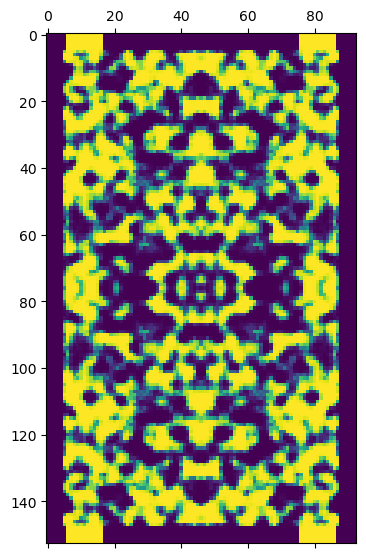

In [6]:
plt.matshow(mapping(np.random.rand(Nx,Ny),0.5,64).reshape(Nx,Ny))

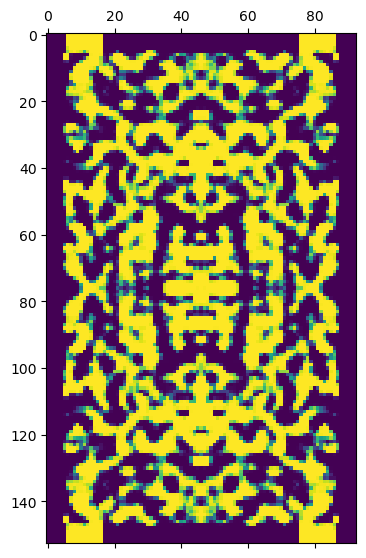

In [7]:
plt.matshow(mapping(np.random.rand(Nx,Ny),0.5,128).reshape(Nx,Ny))

In [8]:
input_flux, input_flux_data = straight_waveguide()

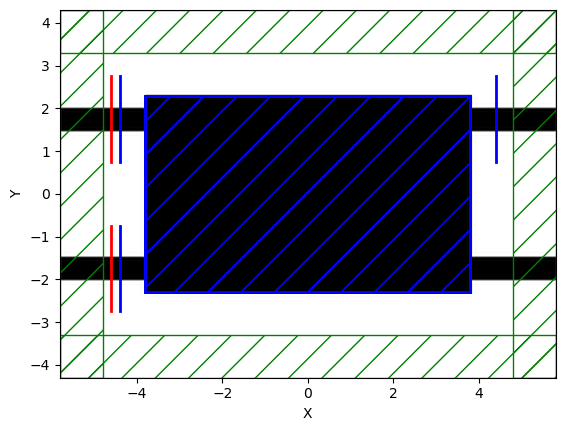

In [9]:
op=dc_optimization(input_flux,input_flux_data, beta=64)
op.plot2D(True)

## Gradient visualization

In [ ]:
x0 = 0.5*np.ones((Nx,Ny)) #+ np.random.normal(loc=mean, scale=std, size=(Nx,Ny))

#just for the same of a boundary value
x0=np.where(x0>1,1,x0)
x0=np.where(x0<0,0,x0)

#x0 = np.random.rand(Nx,Ny)
f0, g0 = op([mapping(x0,0.5,2)])

In [ ]:
np.shape(g0.T)

In [ ]:
plt.figure()
print(g0.shape)
plt.imshow(np.rot90(g0[:,0].reshape(Nx,Ny)))
plt.colorbar()

In [ ]:
backprop_gradient = tensor_jacobian_product(mapping,0)(x0,0.5,2,g0[:,0])
plt.imshow(np.rot90(backprop_gradient.reshape(Nx,Ny)))
plt.colorbar()

## For the phase, 2 things must be considered: 
1. The top input and top output are inphase
2. The top input and top output had a phase difference of pi/2 with the bottom waveguide

That's why we use "Phase injected topology optimization" ( Read more here: https://pubs.acs.org/doi/abs/10.1021/acsphotonics.2c01016)

Starting forward run...
Starting forward run...
Starting adjoint run...


/home/satadrudas/anaconda3/envs/meep/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Calculating gradient...


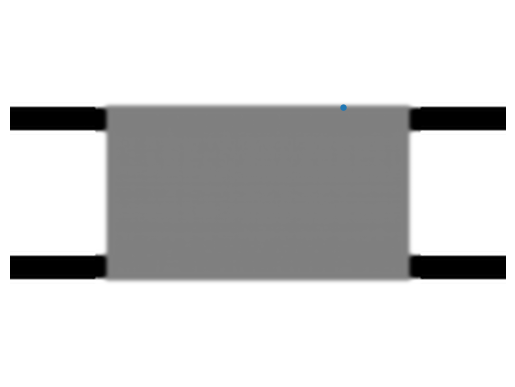

iteration:,   0, eta: 0.5, beta:  8, t: 1.02563, obj. func.: [0.05348849466468561,0.054111484831244894,0.052776661247562744,0.04965656389921036,0.045425517406142896,0.040653897133214496,0.03576046761974412,0.031070984608197492,0.026835991414518336,0.023262184752851866,0.020545527100303888,0.01886121111001369,0.018317088375160873,0.0189000127992996,0.020405929397504605,0.02235725363907059,0.024043580804382177,0.024870354247504816,0.024735282821307547,0.024031056317646137,0.023466647129046198,0.023390948670668772,0.023636718290292354,0.024006756642399082,0.024156520708643638,0.023743995794890393,0.022722427865723406,0.02132632022978062,0.019874713904005407,0.01862229093665161,0.01772952283347557,0.017293534143229032,0.017381072893722396,0.018045376271964276,0.019328205814751382,0.021249293860109115,0.023781142252357723,0.026811885531426456,0.03011220245298194,0.03334218706165472,0.0361485076518874,0.038363941000392775,0.040128459588903584,0.04157065256428135,0.04225657249502954,0.0413165

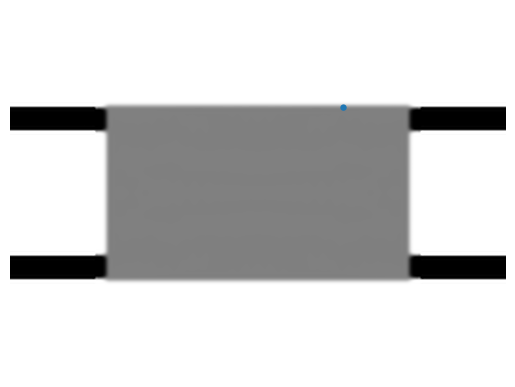

iteration:,   1, eta: 0.5, beta:  8, t: 0.97611, obj. func.: [0.05486869579601174,0.05587701843887507,0.054777142429122384,0.05165026499877616,0.04721502675648591,0.04213823483291526,0.03691644450852695,0.031919507492915056,0.02741575283866225,0.023617708464049456,0.020719165939849477,0.01888706404378157,0.018217489344692462,0.01868844547576941,0.02009542453084036,0.0219731808294672,0.02364099298168335,0.0245440628238385,0.024605654877858086,0.024174056563974478,0.023866387116513642,0.023997828733319192,0.02440659622383345,0.024878265584781165,0.025062288949079473,0.024639425595972327,0.02359019335830789,0.022167166645455438,0.020693847323366665,0.01942419135066144,0.018516504013668226,0.018067079729299648,0.018142243894997443,0.01879515484401246,0.020067732383278622,0.021979906212396868,0.024504063760097693,0.027526490804037795,0.03081395959873141,0.0340220483202317,0.03679962457763855,0.03899569795656962,0.04077516210839933,0.04227580660642772,0.04305129668468091,0.042199743002563225

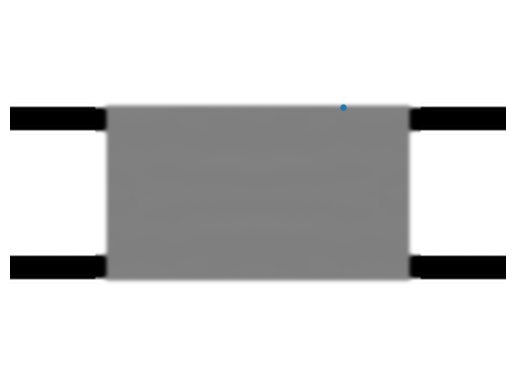

iteration:,   2, eta: 0.5, beta:  8, t: 0.96524, obj. func.: [0.05632299280740268,0.05760923801989354,0.056624355775467296,0.05339797667505744,0.0487114820007479,0.04332074666341479,0.03778941303713053,0.032514099682611604,0.02777161964353171,0.023772867796318417,0.02070851438379589,0.018734465458855133,0.017934730355151803,0.018277021914499945,0.019556545054797994,0.021320093189675,0.022924258304402416,0.023873246302182568,0.024136737051472693,0.024017675024732038,0.02401191655306504,0.024369486813801203,0.024935743552653794,0.025488532461974172,0.025680618443000586,0.025226774028778973,0.02414520228891344,0.02270702110487791,0.021236061344529128,0.019978837470642677,0.0190875541278295,0.018654834702466584,0.018745957654635697,0.019413597612150345,0.02070054756904752,0.022626793569822008,0.025164145517575565,0.02819411744459356,0.031475535472038414,0.03465464762092715,0.03738162460765033,0.039527735181976234,0.041292158305171016,0.04282320963005009,0.0436545387775039,0.042852977085760

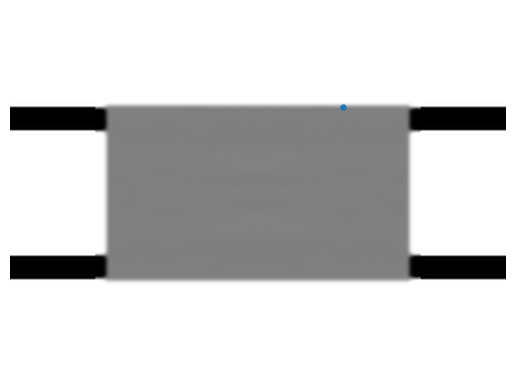

iteration:,   3, eta: 0.5, beta:  8, t: 0.95584, obj. func.: [0.056324195967252216,0.05792380103405023,0.05713729698183085,0.05392171425090111,0.04910750870974023,0.04353834000772537,0.037832813663918455,0.032408691897950107,0.02754185671892885,0.02343860289034498,0.020280290704762352,0.018212376283440208,0.017307989700927583,0.017535084400966773,0.018701803081445062,0.02038774974902481,0.02198726557329703,0.023030076028480378,0.02349476434181401,0.023677608122447714,0.024008807669070202,0.024663446572796115,0.025432317346355003,0.026066328235677824,0.026240226506955386,0.02571953492061346,0.02456581402687446,0.02306973328088312,0.021555548959899196,0.0202628036643549,0.01933791691263554,0.018870228308937514,0.01892355723228637,0.01955048042950251,0.020794752599230474,0.022679333755603978,0.02517952201432566,0.028180462039587576,0.03144130720400755,0.034606632516142016,0.0373247858108902,0.03947246407761536,0.04126020429647306,0.04284761594689812,0.04377668178270348,0.04310676798220583

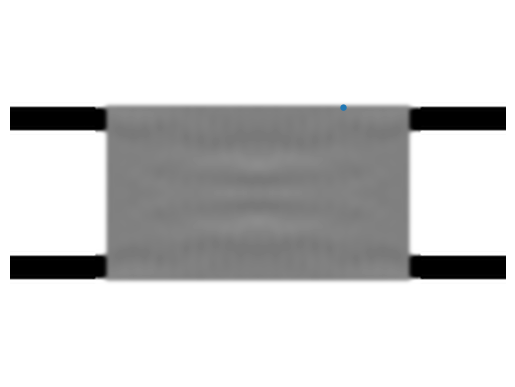

iteration:,   4, eta: 0.5, beta:  8, t: 0.88023, obj. func.: [0.0487389602059281,0.051550097793290874,0.050975802779511026,0.04741062843823213,0.042261598625283836,0.03672657035109486,0.031444922422491244,0.026653017116932222,0.02242110700982748,0.01879618713208661,0.015836137622090473,0.013602862459631196,0.012160119151642097,0.011558748485554826,0.011785644079498888,0.012695914683893108,0.013989636663500482,0.015323055462765934,0.01652175923187846,0.017630020056234364,0.018757095293424453,0.019868536370926393,0.02070119581656068,0.020962157071699777,0.020537675167286506,0.01954702196921822,0.0182421875234322,0.01687225191540675,0.015617609846232092,0.014596119700691405,0.01388996023991871,0.01356357491787032,0.01367174079741257,0.014262751378706893,0.015376945550698382,0.0170331043424385,0.019195612357387745,0.021726760494472527,0.024361356613121332,0.02677568959215271,0.02880276719247886,0.030649033262975175,0.03270530155076501,0.03493533049254882,0.03662449165045967,0.0367809774912

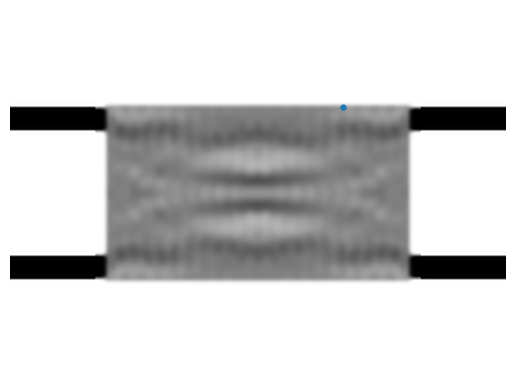

iteration:,   5, eta: 0.5, beta:  8, t: 0.38567, obj. func.: [0.02448706507747958,0.02655822467219393,0.03008833726607521,0.035388606784291274,0.041965420961322365,0.04877283990843749,0.0545757411884896,0.058358930838643276,0.059650062868941284,0.05863165612053531,0.05603847003288664,0.052930746560219455,0.05043423044827774,0.049501602713537256,0.050711743741986504,0.05406541707285752,0.05875496706738384,0.06317824004371543,0.06568310578502166,0.06570344671794932,0.06396059377478351,0.061470897145499484,0.05871607287736512,0.055710238053526207,0.05238494994167775,0.04877418522150471,0.04499592049336965,0.04118231654084143,0.03745311900347504,0.033953325081143106,0.030917934928144642,0.0286927278652152,0.02763370970802453,0.02788564791724612,0.02918901015707932,0.030967771684282833,0.0327795521301412,0.03483120735121365,0.03808280569701385,0.043791361028632875,0.05281442414015797,0.065083370621636,0.0793403660996207,0.09296987891641316,0.10210571869839859,0.10306101703579086,0.095311799

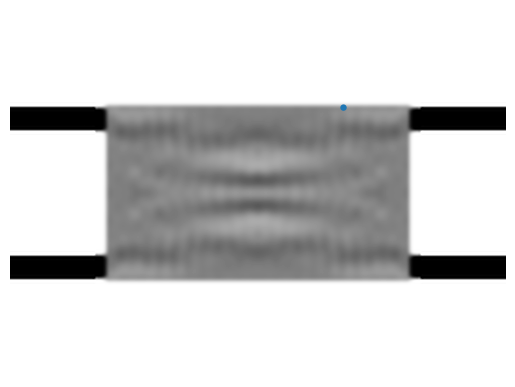

iteration:,   6, eta: 0.5, beta:  8, t: 0.55371, obj. func.: [0.061899818612601853,0.07184756414278853,0.07964731081842244,0.08593583600891229,0.0911312841790529,0.09527691528075649,0.09811585724459629,0.09928102346576761,0.0985198281490273,0.09588981115880277,0.09185504414489251,0.08722736179918202,0.08294756180030705,0.07969972519889677,0.07735200448065324,0.0745824921278988,0.06961138149031897,0.06226531594728107,0.05520746199529535,0.05158258849617024,0.05184358246921728,0.05428067562899171,0.05704923555661935,0.058946313310561695,0.05935891525194067,0.05810858698627566,0.05534419861642975,0.05145132720599361,0.04695819507662656,0.042448595608133764,0.038503478036611805,0.035681663811154195,0.03451799718508897,0.03547025105360561,0.03872343178665622,0.043916490470041106,0.05019476900341795,0.056774868545762296,0.06336583440392568,0.06998930891255861,0.07658999825243344,0.08276151494764979,0.08751368999852896,0.08905704642680908,0.08523659726895112,0.07570817997713127,0.063739730089

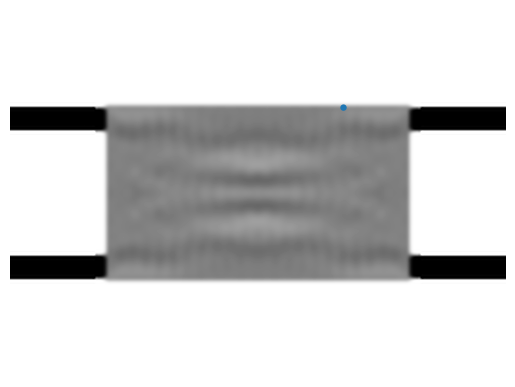

iteration:,   7, eta: 0.5, beta:  8, t: 0.66223, obj. func.: [0.028553879442912267,0.034748647458937604,0.040038948606265355,0.04381160907955654,0.04581930467586082,0.04616582614693667,0.04511335992199496,0.04292236680367317,0.03979276856219352,0.03588972113443287,0.031404092267342816,0.026589703429571017,0.021747537624144598,0.017175541532542696,0.013126943634942054,0.00979649465206558,0.0073188987653531054,0.005745284545770116,0.0050225677037155705,0.005132518818792215,0.006221783997591932,0.008214722427754163,0.010590867042155306,0.012819595263242658,0.014595268725838268,0.015766262973976423,0.0162604592645144,0.016064732867763925,0.015226541830640173,0.013855498120393663,0.012115157938044551,0.0102016657721043,0.008315369781778903,0.00663541510851609,0.005306362761487928,0.004443654975526861,0.004164513124489709,0.004639455231009524,0.006106491923679674,0.008739675555454756,0.01242113325672655,0.016706941924264883,0.02103027115220892,0.024853017250397267,0.027650637359484125,0.0288

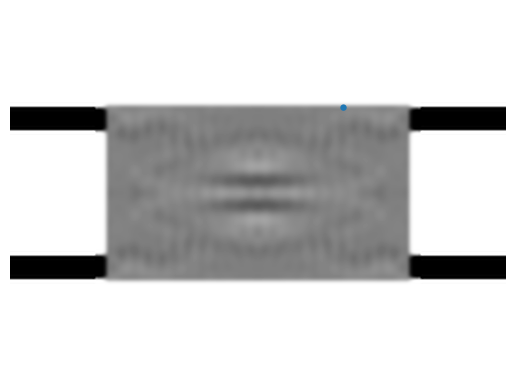

iteration:,   8, eta: 0.5, beta:  8, t: 0.48396, obj. func.: [0.013406290157982904,0.017386093586265146,0.021540846449855263,0.025015540118873962,0.02711902245964749,0.027553398584733275,0.026412517514307295,0.024027587279840515,0.020805109880699165,0.0171439769512812,0.013409455749721376,0.009911500347295633,0.00687982357480227,0.004453973600243685,0.002695031808607154,0.0016077083056753822,0.0011446545271908551,0.0011669673191066741,0.001437395026077294,0.0017746239128047022,0.002154750372642348,0.002582971674069357,0.003015279202668426,0.003395461108162832,0.0036884358173513983,0.003879562596496659,0.00396573063491302,0.003949699456961729,0.003835288230872013,0.0036241956670842643,0.0033170312545935028,0.002917744250354384,0.0024386784157959035,0.0019052690851977742,0.0013591483241762305,0.0008545403181337811,0.00044380102490997113,0.00015998330655116508,1.9797169964317987e-05,5.882090287884998e-05,0.0003504539522811109,0.0009533877772610754,0.0018435191382527316,0.00288364835521773

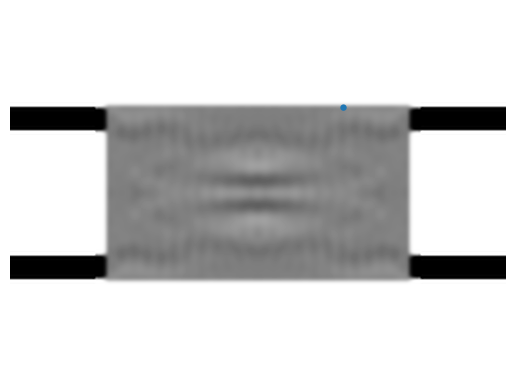

iteration:,   9, eta: 0.5, beta:  8, t: 0.53217, obj. func.: [0.022347337949753895,0.026917031284801517,0.03038380245852494,0.03227250143643767,0.03246949784074587,0.031147561505671766,0.02864698131806201,0.02535903126111343,0.021644449561444262,0.017802893217228593,0.01407744875730319,0.010668090063029347,0.007732486349719436,0.005382582888393982,0.0036759476925901616,0.0026050305250780803,0.002076241557784731,0.0019097610830245122,0.0019352126346970646,0.0021636053737257447,0.0027196878935924003,0.0035698685506895555,0.004525421741795575,0.005398360029366187,0.006059530364128691,0.006431045283928238,0.006476160181359602,0.006195236192369886,0.005624124453929506,0.004829309538875642,0.003901169207691523,0.0029420830606483516,0.0020522761572484677,0.0013138632876968591,0.0007788404871968249,0.00046326983864182936,0.00035483306662868747,0.0004434892181699719,0.0007785233255059,0.0014881710866177286,0.002666194549664817,0.004237561392948432,0.005978298663667102,0.00759569636255111,0.0087

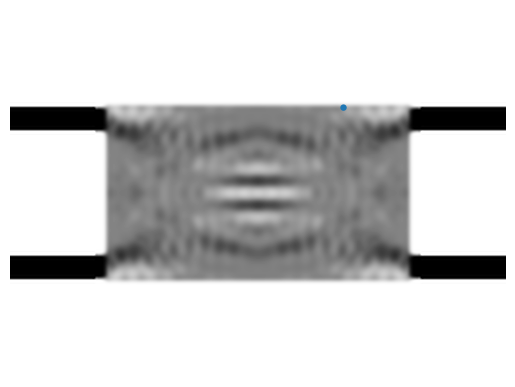

iteration:,  10, eta: 0.5, beta:  8, t: 0.17026, obj. func.: [0.04116866189104118,0.0463149393378682,0.057825031241546074,0.0723733836048858,0.08864579693206653,0.10596593113934034,0.12347019260440399,0.13990434315926822,0.15379361239237085,0.16378979005553312,0.16899239012716658,0.16912618158677745,0.164439667825987,0.15526499761946452,0.14175931878033857,0.12433083523620181,0.10413337332190196,0.0829803140085462,0.06285819534647054,0.04545368184445853,0.031938881999767604,0.023023301956208997,0.019059721887343912,0.019924324808420976,0.02463773774792969,0.031242664235125055,0.03784866476269259,0.04432211373115652,0.051913785751791605,0.061270981684186564,0.07163515231357474,0.08150496473827516,0.08959171414539889,0.0952466096637347,0.09834466366717294,0.09900813516761288,0.0974613711163437,0.0940082352456537,0.08902268815616429,0.08292178749489991,0.0761404534230793,0.06912124961579195,0.06230727074900839,0.0561148484273989,0.050866157727909894,0.04670073461303535,0.0435356378752079,

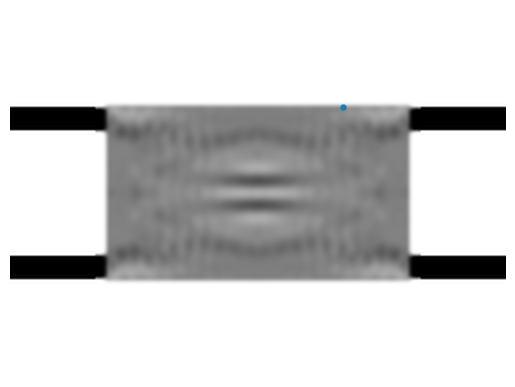

iteration:,  11, eta: 0.5, beta:  8, t: 0.39190, obj. func.: [0.020150052389519925,0.027558657867982058,0.03397339412967854,0.038721332941392426,0.041631311990532285,0.04296417583102098,0.043202728040320215,0.04281630567169237,0.04213510963576005,0.04134740762618312,0.04050152725653166,0.03944005431002109,0.037744801808620526,0.034847643665523904,0.030431100535225113,0.024960764547390935,0.019599187269735318,0.015392563641738976,0.012803050591152663,0.011807584927316414,0.01228609135724955,0.014400036754677265,0.018048249011179525,0.02259658188122517,0.02730567250249792,0.0315237643275315,0.034752364721740196,0.03673109436151033,0.0374926165269254,0.03734805083882062,0.03679294244058357,0.03637183059474703,0.03654770453373008,0.03757196181302893,0.03931326623264285,0.04103871359479833,0.04146954954012816,0.039657985864869016,0.03606234747561278,0.03219003410330717,0.029311670439367946,0.027905972415300927,0.0278644594555287,0.02881889629953865,0.030327351771630137,0.0319118827975546,0.

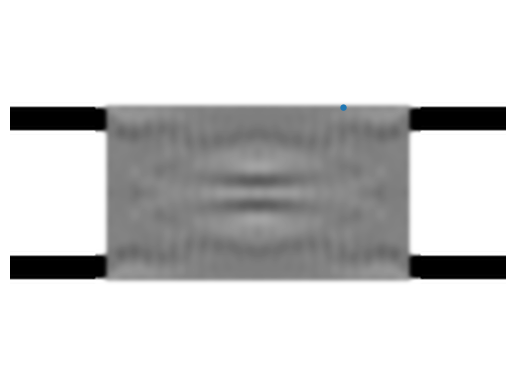

iteration:,  12, eta: 0.5, beta:  8, t: 0.47793, obj. func.: [0.021055268740809863,0.02400364034474467,0.025890621773345827,0.02662889420678683,0.026294278779669698,0.025038256694602967,0.023032916250479114,0.02045954434846194,0.0175145615068033,0.014406871349182443,0.011342674331587385,0.008507594033298272,0.006053909254598188,0.004093387146230234,0.0026915210205216127,0.0018605633570545164,0.001558150964510294,0.0016997071634982646,0.002166084925062728,0.0028510973054333547,0.0037884817950460956,0.005025140819336355,0.006439641562530111,0.007825590359336288,0.008984650468472416,0.009759650935775088,0.010049431085060874,0.009817829617356895,0.00909631827100571,0.00797794267584555,0.006601502560131842,0.005128579756002624,0.0037187838539369726,0.00250730659335114,0.0015849009608669027,0.0009790662438119175,0.0006464643599232151,0.0005174918145282721,0.0006209147003496573,0.0011370231166889923,0.002213374761203657,0.0038067340449608384,0.005744049984215606,0.007814005276043381,0.0097697

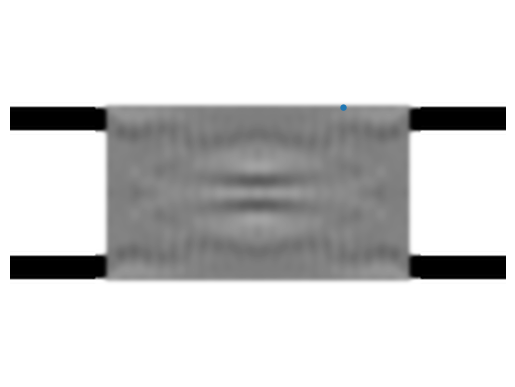

iteration:,  13, eta: 0.5, beta:  8, t: 0.48036, obj. func.: [0.02344828820837538,0.02624320914166875,0.027904779268349344,0.028394581138605497,0.0278133480278574,0.026321818069618197,0.024095983928912972,0.021321916349139863,0.018202778548265065,0.014953830011201222,0.011784712280606765,0.008880776028038152,0.00639119242092195,0.004423423004489193,0.0030392978428545213,0.0022493019030613614,0.0020077691091928197,0.002213701457594122,0.0027196573162172367,0.0034220848872220343,0.004381745708077095,0.005630641935884147,0.007024477484810671,0.008352595683480346,0.009423682434046886,0.01009367982003746,0.010276708617347162,0.009949900910921404,0.009152813970826955,0.007980531978189867,0.006569313871038913,0.005075773326018397,0.0036539883386181816,0.002434300054737345,0.001504575822960291,0.0008948576754195075,0.000577381591669558,0.0005173785052109114,0.0007734861510034194,0.0014932272091319147,0.002743463015838445,0.004434730713378486,0.006396751315042328,0.008436241960577478,0.01031686

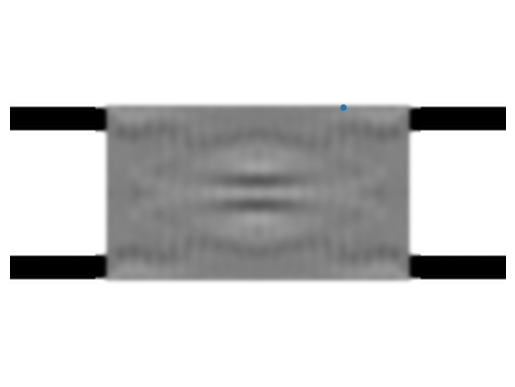

iteration:,  14, eta: 0.5, beta:  8, t: 0.45281, obj. func.: [0.02511997442570475,0.027292394850780447,0.02821455675865171,0.02789433998691925,0.026491769892773735,0.024241416984542387,0.02139527744556413,0.01819317694315538,0.014854212708482339,0.011575191801548304,0.008527576684516305,0.005853436168802422,0.003663077792889413,0.0020337923030341563,0.001004619313608027,0.0005604759500040821,0.0006118332372611368,0.0010034690303072304,0.001585259072538931,0.002310754598201979,0.003187137131818502,0.004150893342277543,0.00508734670958997,0.005880939937252129,0.006434279107560496,0.00667868319874285,0.006583452110292288,0.0061606765477382665,0.00546345332537999,0.0045773492504915456,0.0036064010744730015,0.002656362678852045,0.0018182883193880223,0.0011543697784846616,0.0006862022113486477,0.0003861347396059314,0.0001851355086472572,3.692481932775946e-05,2.2337104180671254e-05,0.00031305450356097347,0.0009894485512426446,0.0019867333874041674,0.0031674757898540675,0.004361843226915621,0.

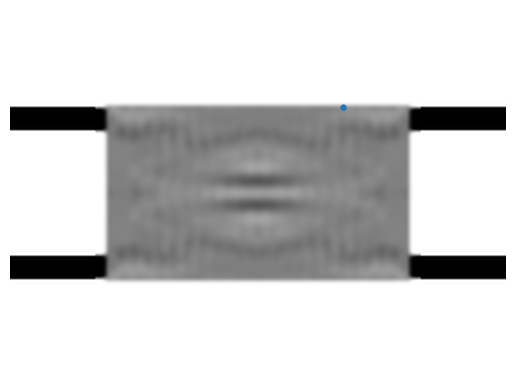

iteration:,  15, eta: 0.5, beta:  8, t: 0.42957, obj. func.: [0.026128627716103962,0.027574572840166414,0.02796711454214185,0.027372987288917103,0.025920571509931368,0.02376040545137918,0.021059203472519133,0.0180028633490121,0.014788041965431783,0.011604800321776413,0.008622446507979874,0.0059828076880271905,0.0037980289721781134,0.0021481733647967937,0.0010740730845248433,0.0005659591075537283,0.0005597246164850467,0.0009477748449884025,0.0016024019398995205,0.002445706385037721,0.0034564024621335236,0.004570078199247334,0.005669469177425065,0.006623975192593898,0.0073164025491321266,0.007661155571917877,0.0076170888840340805,0.007193676612581752,0.006448921582006717,0.0054784129475446315,0.004398636426568802,0.0033289065252415716,0.002374631481284266,0.0016112980685758995,0.0010646699931814562,0.0006894567664969902,0.0003842478593948677,0.00010927154743685174,3.7218199965054946e-06,0.00025541826623693635,0.000909251114005079,0.001880967154887713,0.003041633389519076,0.00424646624747

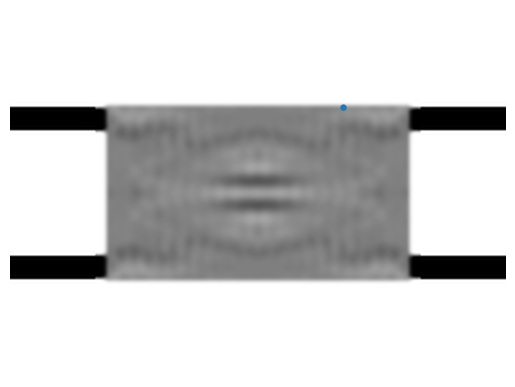

iteration:,  16, eta: 0.5, beta:  8, t: 0.41076, obj. func.: [0.027138534553823847,0.028172362828160772,0.02820568190076304,0.027294095912705946,0.02556920142294144,0.023199457065454218,0.02036819579115746,0.017262535682791593,0.014064608234956593,0.010942413969972468,0.008044127162361706,0.0054948262566179825,0.003395210942394255,0.0018182728430158194,0.0008000820806412401,0.00032481690871804674,0.0003211213744736855,0.000677800452560989,0.0012765323428809417,0.002044882439617912,0.0029339331681380097,0.00386684142473632,0.004747329060875365,0.005479696006298861,0.005983093823519017,0.006203965395216693,0.0061240787874648215,0.005763787926160737,0.005177784780720696,0.00444538896173432,0.003656886784503361,0.002899435042307196,0.002244144504558799,0.0017324234332827112,0.0013591208916466826,0.001057919017980659,0.0007375892566640718,0.00041338070663289296,0.0002627272790905195,0.0004461660330252669,0.0009774404237206193,0.0017747466863289496,0.002726994139143315,0.003703021078725859,0

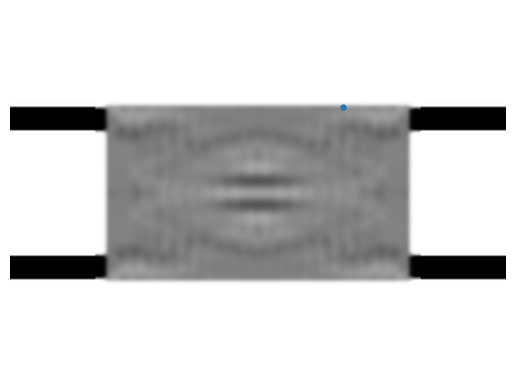

iteration:,  17, eta: 0.5, beta:  8, t: 0.39528, obj. func.: [0.027484084489163178,0.028110779203552715,0.02786995057795977,0.026813800564462018,0.025039182936898708,0.022676931463795364,0.019886334009440284,0.01684155568602144,0.01371610019852216,0.010670957221227824,0.007848958059099045,0.005371804071006908,0.0033368206026592375,0.0018111328846746161,0.0008220811828027301,0.00035023928484262753,0.00033660706797418775,0.0006913757999686062,0.00131270959700324,0.00213326253370842,0.0030969402573155095,0.004117837094296651,0.005090568837727349,0.005910463600206795,0.006489083701154549,0.00676778558697758,0.006726480224498223,0.006386369032412734,0.005804498317087248,0.0050622059533778655,0.004251317312149469,0.003460605860208416,0.0027631861966493443,0.0021998492290474683,0.0017559238124757,0.001351455368061984,0.0009158313914482632,0.0005309454988964411,0.0003906290639058098,0.000602246722043345,0.00114221177605079,0.00192663863921044,0.00285526748430146,0.0038065325033129816,0.0045987

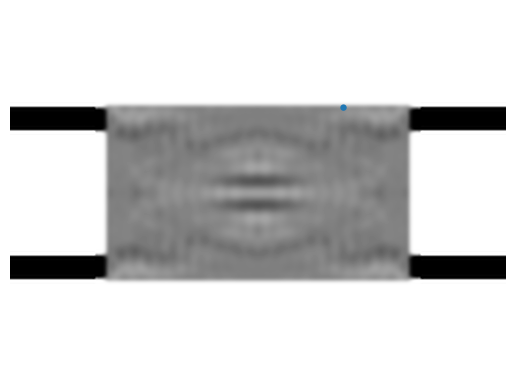

iteration:,  18, eta: 0.5, beta:  8, t: 0.38496, obj. func.: [0.027907035412415744,0.028336854447498457,0.027948457940379038,0.026790624096824006,0.024960043955363994,0.022586755642179962,0.0198212086747567,0.01682372302877732,0.013753431692200595,0.010760549059405886,0.007981046551020485,0.005532113406015152,0.003508230121442771,0.001974872610046461,0.0009596089544666932,0.0004456909918485647,0.00038017502578701983,0.0006839645455546029,0.001269124381618484,0.0020663705988401226,0.0030037469747764096,0.003989356355214953,0.0049225355732111335,0.005708390459202229,0.00626973994882996,0.006558598666029713,0.006562285829279458,0.006304452051415437,0.0058380332394187455,0.00523495553384901,0.004573346606641714,0.003926562056329835,0.0033508077134832715,0.0028692899396523448,0.0024498770129357758,0.0020069530192704165,0.0014986622775882146,0.001051965139030752,0.0008645277534924579,0.0010198822448301557,0.0014834851362064431,0.0021738519663411014,0.002997332957154348,0.003839672122126989,0

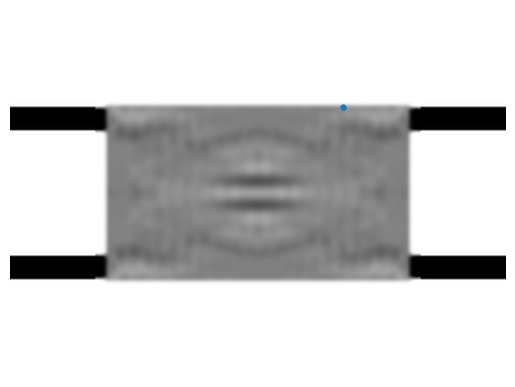

iteration:,  19, eta: 0.5, beta:  8, t: 0.37731, obj. func.: [0.028163396846247548,0.0284860043554502,0.028042836884169295,0.026867907927088916,0.025042071996873232,0.02268382997068836,0.019937697860146937,0.01696029529574249,0.01390848447357208,0.010931034726163791,0.008162602729029165,0.005718684665590773,0.003691076244786426,0.002143411731353983,0.0011050851337988839,0.0005657895677329072,0.0004799251112731458,0.0007776720983794483,0.00138225269803613,0.0022221670537008187,0.003213561195693592,0.004256137992334536,0.00524505050976113,0.006082959504072722,0.00669180652862939,0.007023394544250945,0.007065605553591094,0.0068418021987466625,0.006403642936740863,0.00582010783529212,0.005166080318680198,0.00451189182606879,0.003912150304868002,0.003389571965967256,0.002913819916023488,0.002408960051706881,0.0018561764784979732,0.0013934549618540072,0.0011966792977879024,0.0013278051740785158,0.001748684793971893,0.002382248181066038,0.003138621094304531,0.003908702211137876,0.004544619512

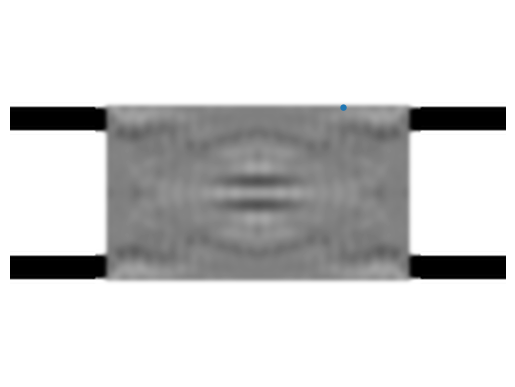

iteration:,  20, eta: 0.5, beta:  8, t: 0.37200, obj. func.: [0.028423333019132774,0.028589737588330905,0.028026540338299457,0.026770450797261175,0.02490179369656201,0.022533876138682116,0.019802537093887886,0.016855060324429197,0.013840352589276664,0.01090140336490974,0.008168472555268284,0.005753435680594622,0.0037449414571231825,0.002204513980976582,0.0011616592265314052,0.0006087211042755143,0.0005048315222517266,0.0007868862617750345,0.0013825022950527672,0.00221601761056519,0.0031986794616853526,0.004230669185342487,0.005211075164335004,0.006048000460704332,0.006669067939337829,0.007030555807237659,0.007122362933955863,0.006966235523618653,0.0066087159138325845,0.006111025873484731,0.0055390790209199105,0.004954181887598664,0.004402787641069941,0.003901972369918933,0.003421181348096165,0.0028952773982588807,0.002325151821049632,0.001853712115341489,0.001639923289092079,0.001733158122143968,0.002095806833364381,0.002656409442644108,0.003331583863615546,0.004021603635497766,0.00459

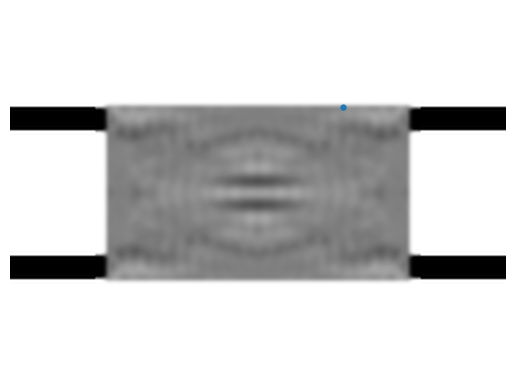

iteration:,  21, eta: 0.5, beta:  8, t: 0.36793, obj. func.: [0.02862489754470703,0.028704728430081927,0.02808095748765865,0.026783515411149802,0.024887208876706767,0.022502033062740595,0.019762145344221268,0.016813403455703743,0.013803708827376245,0.010874757511148957,0.008155093132891885,0.005753860384438008,0.0037561511176612905,0.002220943272892722,0.0011789094544854713,0.0006273602905866032,0.0005300511169960128,0.000828007266161413,0.001451490111202458,0.002321042641002068,0.0033418769178199122,0.004410594157042213,0.005424467689813231,0.006291159512638888,0.006938511989523388,0.007323699244499788,0.007437059277216147,0.007299989865489765,0.006957286842133053,0.006467628002257347,0.0058942491484310034,0.005296562444743608,0.004721210462322716,0.004188947273766235,0.0036787612211854562,0.003139665525646391,0.0025804372492131693,0.002130071521086391,0.0019256626871113956,0.0020087851639112504,0.002345329761470628,0.0028683878940695576,0.0034973912125663546,0.00413697213163619,0.004

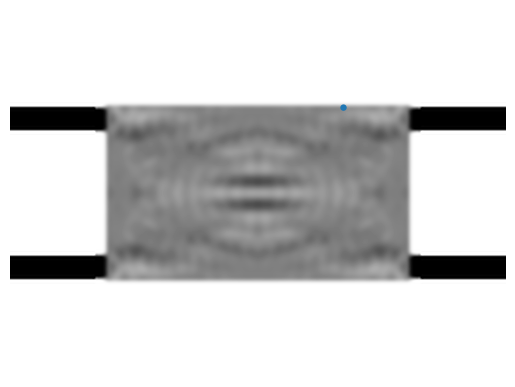

iteration:,  22, eta: 0.5, beta:  8, t: 0.35355, obj. func.: [0.029291919841054406,0.02815476608991992,0.026624642128708197,0.024720574855291184,0.02247614075842778,0.019947629816015083,0.017218134965776326,0.014393984527520514,0.011593384396277778,0.008932517440620194,0.006514242786667381,0.004420737076553556,0.002709537875108736,0.001415079203798622,0.0005553031976884759,0.00013308142240800122,0.00013335009630736748,0.0005164311680556866,0.0012047986448341084,0.0020917682219714997,0.003069339826676881,0.004045713701887241,0.004950808628174957,0.005737731409547701,0.006380293737400585,0.006866557545788671,0.007192326502981538,0.007358495584624571,0.007372306373446218,0.0072494478059164,0.007013962328049168,0.006695435177860848,0.0063245933828792195,0.005928753544823257,0.0055311917025208145,0.005163185203408916,0.0048767605289633375,0.004725137557887286,0.004733478068684641,0.004893391657772007,0.005172746119155715,0.005527364057277067,0.005908171883567628,0.006263021125529261,0.00654

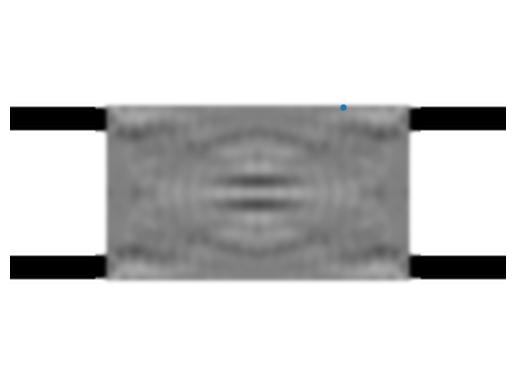

iteration:,  23, eta: 0.5, beta:  8, t: 0.35914, obj. func.: [0.028796793385294252,0.028137725762353297,0.026924422047240718,0.025197220409715063,0.02302126006508307,0.020486602372215647,0.01770451211188773,0.01480204053060367,0.01191164456802985,0.009160965503835543,0.006663015766059787,0.004509930292917416,0.0027682505986769564,0.0014764932590996661,0.000644771311740192,0.0002593341195078221,0.00028993101937795323,0.0006929533536938994,0.001402181639357944,0.0023252224815729517,0.0033592070368393357,0.004404240762369392,0.005371313002103306,0.006189339511490614,0.006811573398102984,0.007216852527181719,0.007406517145838129,0.00739813967386389,0.007220825029297389,0.006911117004268446,0.006509861527980772,0.006056523981685197,0.005581808933513832,0.005097100983971432,0.004592526381367821,0.00407156122551832,0.0036058419808054436,0.0033009858315544605,0.0032153892652388347,0.003346467798182409,0.0036546537543273075,0.0040825430522315985,0.004566424473255183,0.005042712039128158,0.00545

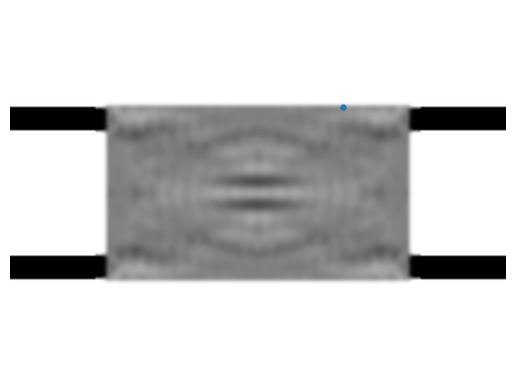

iteration:,  24, eta: 0.5, beta:  8, t: 0.35950, obj. func.: [0.028774764297504155,0.028144405041886308,0.026951636445780462,0.02523788144177532,0.02307026714091221,0.020540051580968194,0.01775963553227756,0.014856532328909154,0.011963793316667935,0.009209485746348839,0.0067072912771744654,0.004549879662255775,0.0028044704515841103,0.001510165570072255,0.000677640986929996,0.0002932331319030961,0.0003264204002761521,0.0007336176364079216,0.0014496928372135778,0.0023831646427413897,0.0034307338510830574,0.00449121033013344,0.005473526125620436,0.006304378593161952,0.006934898509003413,0.007342863885881397,0.007529516497268747,0.00751351235773776,0.007325266517061509,0.007002840959393489,0.006588075548858392,0.0061212800190430855,0.005633286880597326,0.0051350277191435315,0.004614854451919948,0.004074580197390755,0.0035873220226245346,0.0032637692221409178,0.003165925365651011,0.003291908107611256,0.0036010976078946176,0.004034546411214997,0.004526750005972796,0.005012309289109237,0.0054

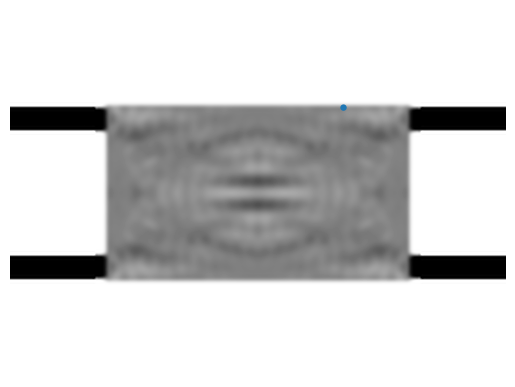

iteration:,  25, eta: 0.5, beta:  8, t: 0.34361, obj. func.: [0.024170333664503246,0.0239775624159709,0.02296486242838825,0.021271284536346576,0.019117596365628844,0.016740447474061216,0.014344662221173112,0.012081555564260427,0.010045605481564713,0.008268048786690508,0.006703774069074841,0.005222381048299354,0.0036736028215694208,0.002091301533580361,0.0008454493881617902,0.00037383716693020286,0.0007949609720283106,0.001916182152755461,0.003429521985775019,0.005033047990927993,0.0064981484482115395,0.007690421540025066,0.008555223656398384,0.009096824630514753,0.009358326106118312,0.009400202284316402,0.009279497952047078,0.009036955502691357,0.00869378593218177,0.00825564069572936,0.007716249357367254,0.0070618501783579115,0.006278332740081444,0.005385113716299748,0.004519048189904432,0.003986052544370152,0.004040983469457459,0.0046376260835012525,0.005557180976664748,0.006612140341746656,0.007679114339239825,0.008666173068935313,0.009487907247286391,0.010068833586135814,0.010369450

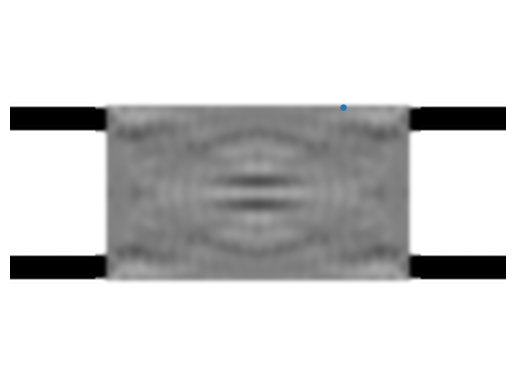

iteration:,  26, eta: 0.5, beta:  8, t: 0.35641, obj. func.: [0.028941962584734,0.028361905511343214,0.027175944224258328,0.02542975004522611,0.023205517986169707,0.020608221754684953,0.017767983211037543,0.014821004985683766,0.011899460827338162,0.009130952605975523,0.006624785128172266,0.0044653326769834,0.002712629454755177,0.0014039772004329828,0.0005614222485035277,0.00018633956676038672,0.00024882058009438607,0.0006947775579058169,0.0014501615554712336,0.002418745473852573,0.003495103298190251,0.004578037396198637,0.005575104208740441,0.006411894370692037,0.00703808389527151,0.007427200678073149,0.007579019532420178,0.007514216733706419,0.007263925905206694,0.006868769883734067,0.0063749419628921136,0.005824933626551069,0.00525928469531704,0.00471645797501395,0.004221315874413553,0.003787696556927364,0.0034389261085304833,0.0032162830009840136,0.00316110272531923,0.0032867034058986387,0.0035694749623342114,0.0039644855379633165,0.004416275910899197,0.004859799727074567,0.00523568

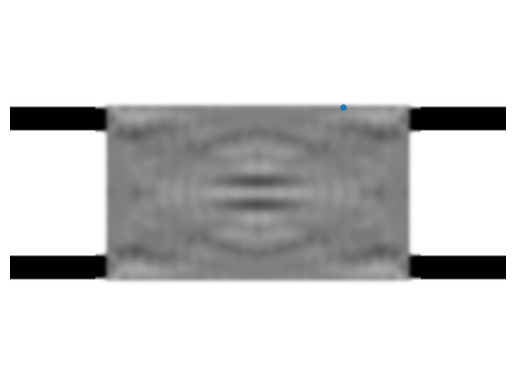

iteration:,  27, eta: 0.5, beta:  8, t: 0.35651, obj. func.: [0.028970459244600795,0.028408522319781183,0.027246971828771997,0.02552521304410174,0.023321050650810818,0.020740339813956704,0.017908758674973456,0.014960900123000668,0.012032546777994129,0.009250770050763966,0.006726752229069482,0.004548349360458515,0.002777436367667971,0.0014527397151726988,0.0005958944188349334,0.00020610535257285575,0.00025310201238040714,0.0006836430668060852,0.0014236740333841192,0.0023774267444153538,0.003440272489411124,0.0045107516283140695,0.00549750672830097,0.0063258941298013965,0.006944942616769973,0.007330059274476384,0.007481441004328862,0.007418262146871568,0.00717303957921741,0.0067861018445319965,0.006301470240409231,0.005762828704101871,0.005210735716387432,0.0046800261504593875,0.004195148361589592,0.003769366860721046,0.0034245119606270795,0.0032059964686287604,0.0031554380685218366,0.0032833751949808278,0.0035674408143003774,0.003962631155686888,0.0044112505664847595,0.00485131354101628

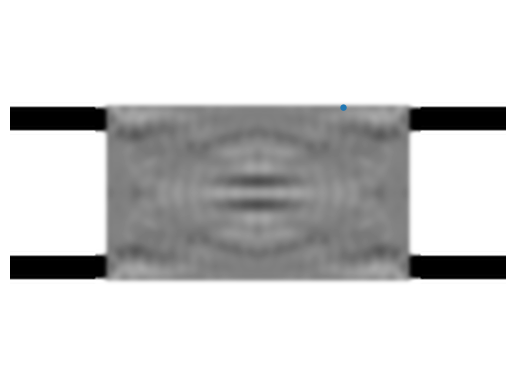

iteration:,  28, eta: 0.5, beta:  8, t: 0.35690, obj. func.: [0.0289159178301166,0.028353669118495673,0.027195150545677216,0.02548008797937577,0.023284514125178336,0.020713028493501668,0.017889569159769154,0.014948168620224073,0.012024135704633431,0.00924486493033009,0.006721874596791022,0.0045439707101153914,0.002774128012788685,0.0014518502034567328,0.0005977327708801732,0.00020885098850750757,0.0002540579003785343,0.0006809118924268288,0.0014165858234615064,0.0023661431199669663,0.003425429098619641,0.004493229711318006,0.005478253794541068,0.006305970279903952,0.006925434295862583,0.007312193569612431,0.007466363517398081,0.007407053651844218,0.007166511523601676,0.006784917922656734,0.006306162281412603,0.0057738452046676835,0.005228148792599551,0.004702620788200195,0.0042193827652943225,0.0037898972748764822,0.0034379313977133553,0.0032128097053458183,0.003158221004042538,0.0032844478132349635,0.0035683258849101437,0.003964105895674573,0.00441379271136593,0.004855383199297575,0.0

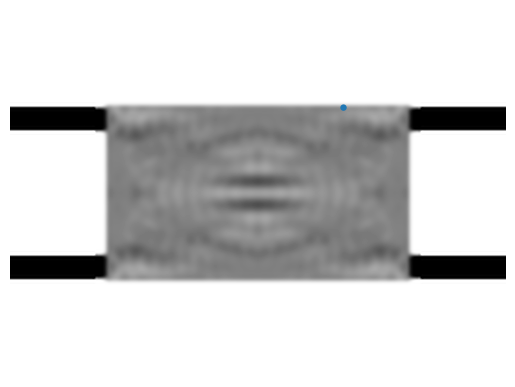

iteration:,  29, eta: 0.5, beta:  8, t: 0.35601, obj. func.: [0.028894499200020806,0.028191075248036077,0.02689195160553375,0.02504748228827208,0.02274354707934721,0.020091769159697605,0.017219330151769036,0.01426026800914557,0.01134737415967378,0.008604237223521266,0.006138234933067579,0.004035091939394199,0.002356065705466592,0.001137533419412777,0.0003899670212247747,9.642127879015599e-05,0.0002173096967624065,0.0006991088305318663,0.0014734467476382469,0.002451596714811183,0.003532874478197307,0.004616935103273402,0.0056119201378318955,0.006442115760122739,0.007055227616869744,0.007426138078625851,0.007555485926357737,0.00746437769034511,0.0071880322029838515,0.00677004174345393,0.006257358492177436,0.005695632651678427,0.005124408151906897,0.004570980026730119,0.00404395946326942,0.003545540950983458,0.003114084046424073,0.00282673791946244,0.0027424061579362706,0.002871777180084687,0.003185492786295818,0.0036299458357108736,0.004139909097554611,0.004646775362701617,0.005086433781

/home/satadrudas/anaconda3/envs/meep/lib/python3.11/site-packages/meep/geom.py:582: UserWarning: The weights parameter of MaterialGrid must be in the range [0,1].
  warnings.warn(


Starting forward run...
Starting adjoint run...
Calculating gradient...


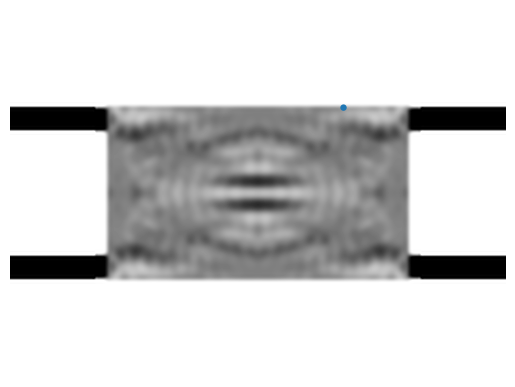

iteration:,  30, eta: 0.5, beta: 16, t: 1.00621, obj. func.: [0.008486733051383784,0.003894343291957393,0.003709349884379722,0.007751843907804549,0.015310833328234248,0.025476213214880358,0.037407514806337167,0.05049635459896629,0.06445807178862537,0.07910065526532534,0.09312717637571735,0.10320363261267645,0.10658846149082978,0.10378547081572663,0.09743946957006436,0.09114410303914719,0.08744531200422119,0.08480885684424108,0.08017143460784548,0.07243856271486371,0.06242312554430829,0.05175329933391571,0.04213151419816822,0.03493047817568124,0.031036347181471333,0.030879253713553965,0.03451210687158815,0.041682942136947065,0.051953686060199455,0.06479410048831807,0.07953063936367993,0.09522923287582066,0.11075130698652337,0.1250195884095061,0.13716260546554082,0.1463877520398159,0.15189457173277557,0.15302430370757844,0.1495181844465146,0.14161627450512276,0.12968840915527668,0.11400527447236757,0.09575598193333587,0.07744859884237473,0.061221206684195464,0.0477190893378193,0.03682049

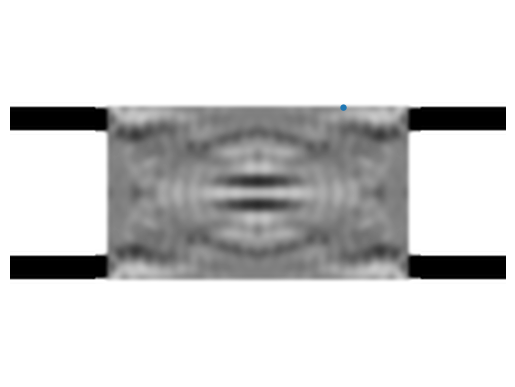

iteration:,  31, eta: 0.5, beta: 16, t: 0.92266, obj. func.: [0.0054684719932301855,0.0015283528116751138,0.0019799918864601127,0.00700902606810651,0.01624201904710373,0.028893460105859692,0.0439354420046997,0.0602774449926728,0.07690810474484949,0.09269421278150704,0.10555922008073905,0.11250153107980285,0.11182703502502403,0.10452061272755765,0.0935327722560395,0.08278361465796182,0.07502854791581053,0.06941377298799258,0.06342584492464702,0.05590806142733153,0.04730418207373774,0.0387786425864983,0.031551284632831286,0.02656898370923578,0.024414509119849874,0.025351203085494843,0.029402390627405205,0.03643060394640505,0.04621998744805349,0.05848354219816834,0.07273304609645664,0.08811766841814563,0.10345129053354478,0.11746264376543207,0.1289986644731235,0.13702154002489014,0.1406210659952918,0.13920043089436282,0.13270376394885267,0.12163264724824548,0.10674256133941427,0.08901430650530397,0.07027165666065611,0.05297521699126892,0.0387770873373872,0.02791008626735791,0.019972845825

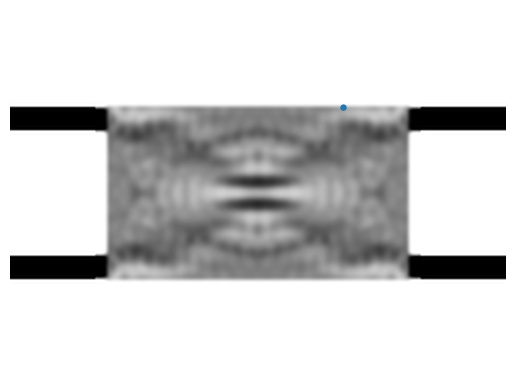

iteration:,  32, eta: 0.5, beta: 16, t: 0.59148, obj. func.: [0.07962213678557287,0.08035550498115582,0.08011677411204043,0.07933035292988858,0.07822048834704588,0.07660538163845981,0.07378089560393405,0.0687933068133488,0.06119691482424662,0.051663471486151365,0.041584515703693696,0.03222477163748159,0.02438425017375781,0.018335174481797313,0.01383329120872909,0.010327045559340695,0.007243433073195261,0.004342211782996769,0.0019083507271907259,0.00046949990934638656,0.00035009321067905417,0.001482656841855982,0.0034878912258027328,0.005839800967566394,0.008005179251306272,0.009551419324698598,0.010233017888518357,0.010031569622095258,0.009107557116664961,0.007679048993656711,0.00594028477297908,0.004103249822383232,0.002467801875788414,0.00139656892958709,0.0011674398735907424,0.0017559619362668994,0.002738359690436211,0.0035741454221378537,0.0040672471954714086,0.004425656859800191,0.004922931941547106,0.005648812608588796,0.006529219018061179,0.007446418135381667,0.00829403167561867

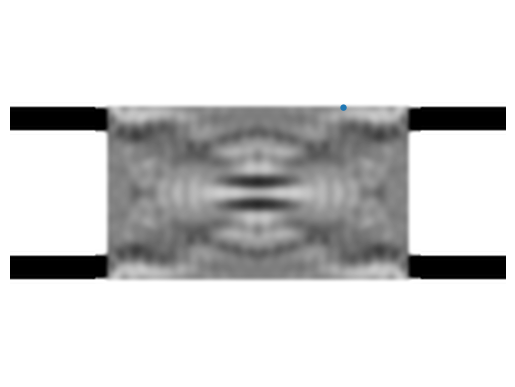

iteration:,  33, eta: 0.5, beta: 16, t: 0.65894, obj. func.: [0.06239067916054772,0.06045733291680207,0.05830042329697841,0.0562625381591887,0.0544347684354939,0.052752454555970614,0.05115093257034014,0.04965890033974579,0.048139041571611405,0.04589763832518007,0.042177779408553544,0.03704233569773762,0.0312023047591757,0.025365178300406074,0.020021928356168426,0.01526612166764934,0.010838975042109325,0.006703378930640289,0.003304969675458511,0.001180851464333612,0.0005465965430642866,0.0012092597081063878,0.002706345710384778,0.004497404486033171,0.006110718637780054,0.007228527485817372,0.007713322101026563,0.007588202899563942,0.006984962226587321,0.00610040537772045,0.005186277452823893,0.004543276798941632,0.004477732187303739,0.0051815710995166495,0.006537924650778541,0.007968677156724514,0.00862780391063735,0.008019656997685016,0.006405911524463087,0.004496713171422895,0.0028914324813733745,0.0018601397103626142,0.001436566969647984,0.0015542827210206418,0.0021004910601219195,0.

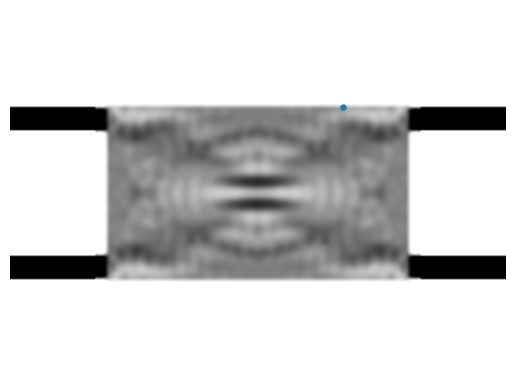

iteration:,  34, eta: 0.5, beta: 16, t: 0.67222, obj. func.: [0.05812388881839071,0.054811979651485876,0.05150613735251761,0.04862988787542043,0.04635689344188226,0.04472790385328346,0.0437918797072952,0.04359923424927651,0.043850285249624955,0.0435431159664155,0.041534381373086425,0.037523043946880046,0.0320766922037648,0.02613258244122516,0.020594919458072125,0.01576989134345411,0.011344725027476002,0.007209233632098163,0.003790719198648829,0.001617735757689608,0.0008992673413120599,0.0014437560116141624,0.0027962284821121995,0.004426946480551628,0.00588076902566648,0.006861133477622751,0.007251946032064828,0.007093242891899721,0.006533424488276011,0.005789891422470668,0.005129566020033003,0.004849972648135096,0.005226515250841559,0.006397181351254742,0.008180008727243695,0.009939137726157633,0.010775470629751326,0.010126865007390396,0.008213633697422626,0.005785055138055541,0.0035500461433135722,0.001898731784488819,0.0009485979988380304,0.000672168151612664,0.0009657895069025142,0.

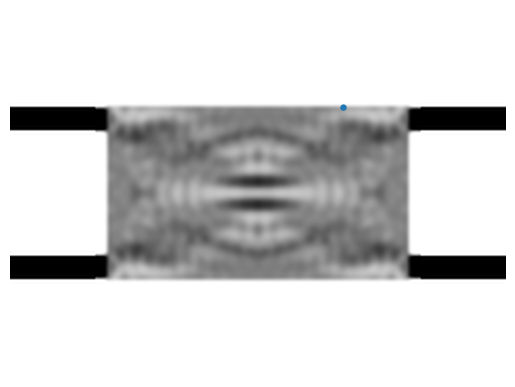

iteration:,  35, eta: 0.5, beta: 16, t: 0.45743, obj. func.: [0.07061899849451082,0.07414912479081806,0.07701660386201108,0.0788978527973128,0.07974283336014244,0.0800166891842751,0.08081504155731016,0.08346742533183164,0.08817412925012848,0.09262748641891044,0.09329316888338261,0.08847749371828473,0.078967185511146,0.06666418668140707,0.05377537264664657,0.04237779329221958,0.03354177078346439,0.02696760545012132,0.02172589021813551,0.01709086206229424,0.012792133570183255,0.008894407114175358,0.005605334309442768,0.0031188949623020172,0.0015217189817828345,0.0007824831130326163,0.000816305244522597,0.0015655625107320761,0.003021984272149294,0.005161464256776456,0.007858822854493479,0.010892869202479356,0.014024939288949153,0.01700140208029771,0.01942424930687181,0.020665118965012746,0.02012429356471047,0.017756650557704663,0.014199455536767882,0.010312841477474369,0.006749223042925121,0.003876054547650441,0.0018512265550402137,0.0006640427947941798,0.00019070476900487666,0.0002990992

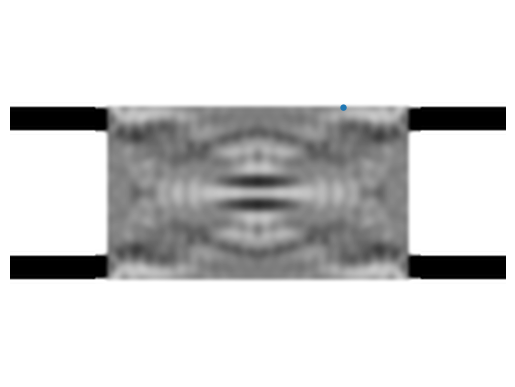

iteration:,  36, eta: 0.5, beta: 16, t: 0.49512, obj. func.: [0.0592686291018469,0.062158165923063606,0.06445419496069167,0.06595908551747265,0.06666800908933547,0.06695078551658361,0.06763571801314992,0.06971945511797592,0.07339576397475481,0.07703369423487991,0.07793596788998688,0.07455138166230499,0.06721241091960073,0.05721092523410825,0.04608751870905905,0.03541960301253432,0.026391273035297137,0.019357354017022387,0.013999994943017374,0.00983356274416142,0.00653825506726247,0.0040065464669643705,0.0022526686975470767,0.001305443589419044,0.0011371325344833206,0.0016515587655544807,0.0027245873336838563,0.004256936536102797,0.0061933425669925685,0.008491033162453213,0.011068287099595776,0.013791241524427367,0.016506760972128852,0.019041398936523738,0.0211008784865839,0.02216227357068659,0.021624176475204697,0.01928694118505823,0.015635797750404426,0.011523798883153892,0.007690403534927119,0.004576123097222304,0.0023772023833581873,0.001124833934626866,0.0007287100858736371,0.00104

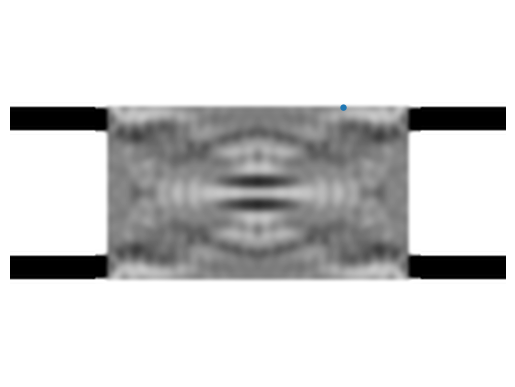

iteration:,  37, eta: 0.5, beta: 16, t: 0.49704, obj. func.: [0.056138825051777204,0.058873335294362616,0.061089289419425666,0.06259438785867927,0.06337805409765518,0.06378325062274169,0.06457205429939412,0.0666175084112102,0.06998558801270278,0.0730947480650584,0.07355372040296392,0.07010777183635375,0.06314130485234393,0.053806231179280115,0.043415928175115706,0.03333476600517968,0.024679339217998992,0.017880025071494228,0.012719855814025322,0.008771255415162703,0.005732259412313434,0.003493310334061633,0.0020589055747146307,0.001444548786490395,0.0016068708016173767,0.00243313453345042,0.0037830839396605725,0.0055428141630952405,0.007646091813145093,0.010047451452029583,0.01267548649449441,0.015417808398908737,0.01814435336751675,0.020694599385203287,0.022768067463637628,0.023817488147218544,0.023219430228586593,0.020776601749290285,0.016991229433236072,0.012729400992888452,0.00873993240144435,0.005470248331386448,0.003117296110797122,0.001713309815265334,0.0011755219136314371,0.001

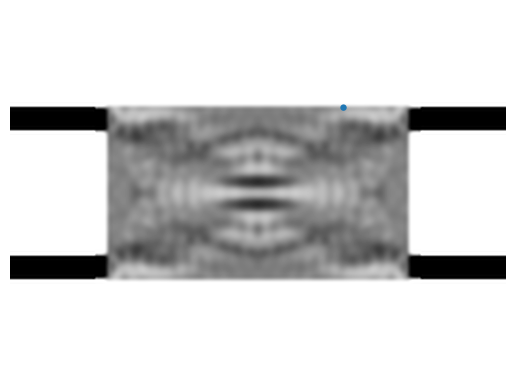

iteration:,  38, eta: 0.5, beta: 16, t: 0.40822, obj. func.: [0.05439135036664274,0.055545969308749776,0.05552544498534373,0.054460307447544175,0.052437338640915,0.049458915593640934,0.045420062794088834,0.04018977239965127,0.03392489403208467,0.02742669189098522,0.021821375855311295,0.017668748878448607,0.014768102327124088,0.012670140173879532,0.011031685510756528,0.009626995502448447,0.008272890929288618,0.006955820475910106,0.005936608560924927,0.005537876126853035,0.005893388073659502,0.006908841089606591,0.008351341203807636,0.009939297952610173,0.011399511178206445,0.012502946374528982,0.013090816297081394,0.013091951724688968,0.012529854047034146,0.011515971716542065,0.010223622683444795,0.008845610931519693,0.007558996889178726,0.006505783815369866,0.005763070404804322,0.005289865701416482,0.00491734401674952,0.004472686512662849,0.003929586701317057,0.0033856660871972623,0.002937347309085362,0.002617557189937832,0.0024196189749049655,0.002350800482222506,0.002449104764282938,

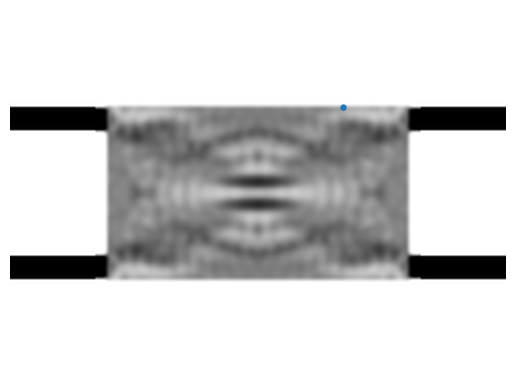

iteration:,  39, eta: 0.5, beta: 16, t: 0.43389, obj. func.: [0.0587816571511702,0.06013826333580206,0.060499142826008226,0.059923109328256424,0.05839808564530245,0.05587349684654506,0.052328855450501637,0.04789341456529506,0.042971836237027806,0.03814922013736846,0.033761643061845426,0.02967470566618383,0.02559292227993203,0.021398543754490764,0.017246428648324073,0.013450117029522627,0.010229610896327823,0.0076706659668649224,0.005875912523566671,0.004923053687640291,0.004759836863518909,0.0052226404389915295,0.0061044640348324394,0.0071974819536373,0.008311279777759605,0.009284090202208741,0.009996472864985567,0.010388427224656724,0.010473818474864534,0.010336663703414966,0.010094514415177329,0.0098455830034182,0.009640795401004714,0.009483368051844694,0.009312963844816238,0.008971380948977812,0.008245259892343156,0.007045527115382342,0.0055235805319781865,0.003955022109257191,0.002568853858449386,0.0014934109455047378,0.000790237279717693,0.0004950331451982053,0.0006206451281452039

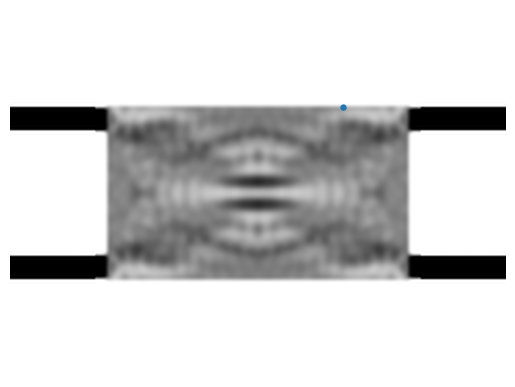

iteration:,  40, eta: 0.5, beta: 16, t: 0.41287, obj. func.: [0.05464149934132097,0.05665522776082533,0.057775125777721516,0.05794471809658874,0.05708258690057569,0.05513106693435565,0.05212511856235666,0.048277735864842665,0.04402363556581674,0.03983931743629672,0.03586849284603849,0.03189579915929468,0.0277223311942855,0.023363737512157777,0.019016667408190187,0.014985425218339097,0.011558219418915022,0.008909526689317226,0.007114133715660281,0.006139377951153871,0.005846250854720696,0.006057953574973706,0.00661621844090676,0.0073906640336619395,0.008267299667356193,0.009140796855146299,0.009920443525893712,0.010548936731185793,0.011022915408646826,0.011390768613022441,0.01170956659998156,0.011990833794614436,0.012192893363060085,0.012249377728871759,0.012071708579208805,0.011521651446358043,0.010448909023377997,0.008842916733411147,0.00691279352342122,0.004961624571925174,0.003232612949705339,0.0018639631591831271,0.0009172141933572625,0.0004188845851056246,0.00037094808073591726,0.

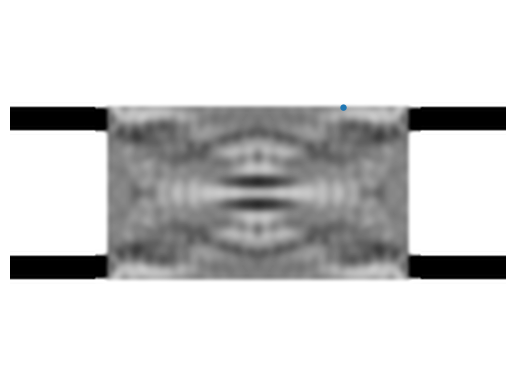

iteration:,  41, eta: 0.5, beta: 16, t: 0.40148, obj. func.: [0.05307138429014024,0.055226913205780395,0.05640708771837083,0.0565667856103707,0.05564501937895082,0.05357955314438098,0.05034151466455157,0.04602527611182087,0.04100220107676277,0.03591510508421725,0.031257207311326855,0.027058261565026286,0.023135006305477233,0.019388787653475428,0.015862140219033455,0.012692802351561025,0.010027737717255215,0.007970572508103528,0.006614511000167789,0.006007977583369617,0.0060810786005579655,0.006671136602937633,0.007592560556626411,0.008674036847979792,0.009765278024938841,0.010737065031378041,0.011487435213705724,0.011957730718386699,0.01215327964451686,0.012145984990306447,0.012029746558712697,0.01185331676956373,0.011602743317740416,0.011235695459555772,0.010699165392977723,0.009914140740244812,0.00879594939049683,0.0073548039271805555,0.005748868088339496,0.004196254751695358,0.0028686269041780076,0.001858527036025982,0.0011974677487965294,0.000895439565295869,0.0009602602477948239,0

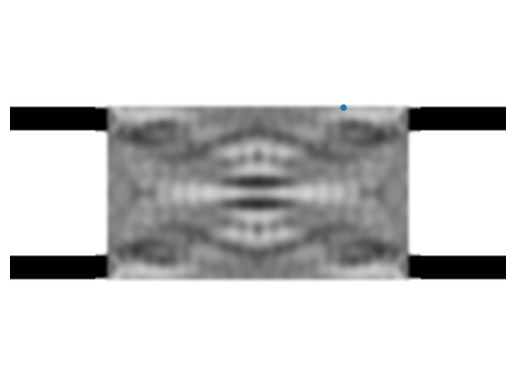

iteration:,  42, eta: 0.5, beta: 16, t: 0.35907, obj. func.: [0.023259222234344932,0.02328474702034834,0.023084291862415403,0.022727582179397132,0.022245856473438984,0.021635455606209993,0.020868607465676186,0.019910138912267956,0.018748848127090528,0.017414892068635095,0.01595802196656418,0.01442108874639498,0.012848259767759086,0.01130716262306199,0.009872013895746814,0.008576960930382096,0.0074273271015846765,0.006479907249168369,0.005859599860523781,0.005654932546823509,0.005832679008583573,0.006278092565287392,0.006878443150814276,0.007551325085369997,0.008233127746279894,0.00886600024804086,0.009389617213001454,0.009755309497169254,0.00996556277279307,0.010083610195977496,0.010176965718649835,0.01025461680621886,0.010270100204234031,0.010167240990980188,0.009905490045573392,0.009468617510102927,0.008888809180855167,0.008256153755264232,0.007675753350644135,0.007225524395281178,0.006980086050927275,0.007042256067674532,0.007487137718214297,0.008273612409297602,0.009258053976085364

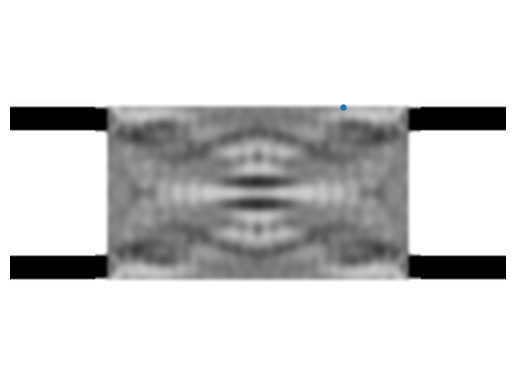

iteration:,  43, eta: 0.5, beta: 16, t: 0.37646, obj. func.: [0.037637671237637414,0.039757727397549826,0.0412667626158658,0.042089557567417286,0.042146413184954386,0.04135668154996108,0.039673836879361865,0.03717812624368412,0.03414797053551025,0.030912582745337522,0.027637387520517184,0.024346116748219394,0.021058437626096705,0.01784608518537018,0.014806583651007236,0.012024516886802707,0.009556355943730435,0.007451910824031209,0.005794186586748157,0.00467939699866572,0.004133666474752639,0.00408910709488253,0.0044327836339538495,0.005047741789532468,0.005820846744374547,0.006638646085301685,0.007391250965673694,0.007997351069544913,0.008446621251413863,0.008810817743464521,0.009163001897746064,0.009482405004361323,0.00967266676567775,0.009639323145507913,0.00932176555446536,0.008688417941682179,0.007754285243064487,0.006621057566913834,0.005454467368663432,0.004409740641375782,0.003600587312802641,0.0031011491301009752,0.0029285304557115565,0.0030368408221233757,0.003370208038013379

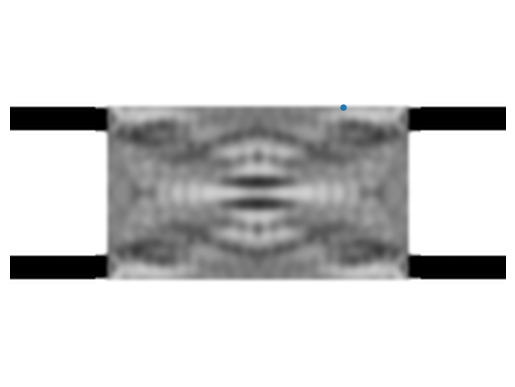

iteration:,  44, eta: 0.5, beta: 16, t: 0.34326, obj. func.: [0.013899220995823186,0.013453102962732864,0.012876211453574631,0.012161014713369386,0.011286129445650777,0.010222492060317282,0.008967088936973152,0.007643586366805043,0.006534348169292055,0.0058912309631396,0.005856627427290027,0.006564379114873278,0.00804299079062744,0.01011869573656289,0.012570832013067188,0.015343576673100462,0.0185131638158659,0.021911707649413838,0.02496249619668864,0.027232791726141358,0.028807204754620896,0.029917348432972474,0.030596602513137457,0.030705065487291194,0.030050637467293008,0.028469951703451415,0.025898331474788757,0.022451194322025587,0.018480155575407105,0.014505115896888025,0.010994074093683385,0.008192762176903207,0.006154642170947813,0.004841942135492018,0.004176714598506937,0.004057641366237664,0.0043705153569140644,0.004981698343493786,0.0057328776105713694,0.006482824860226818,0.0071543286059344395,0.007728029835408107,0.008198239676737846,0.008530469164201053,0.0086707295507732

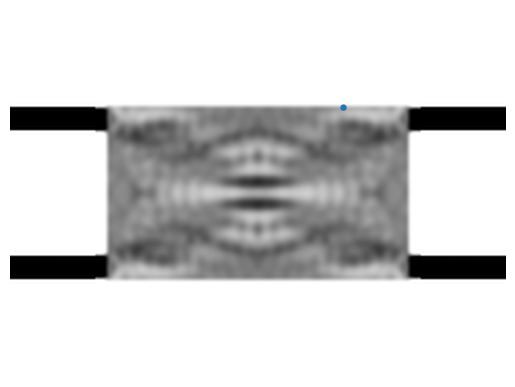

iteration:,  45, eta: 0.5, beta: 16, t: 0.36785, obj. func.: [0.03739689574025802,0.039342023013450335,0.04056995702086956,0.04102029214211515,0.04064841196899874,0.03940965596166007,0.03727566812120042,0.034327603840310056,0.030856020203942937,0.027238624202234885,0.023731316038076707,0.020443894549647068,0.01740925975050545,0.014642582609408485,0.012165543066465645,0.010009220424996407,0.008207469025126398,0.006779553623852153,0.005745332228829607,0.005162084831469822,0.0050698625738491605,0.005415278422169466,0.0060680282948703404,0.006875630182693537,0.007693712923824965,0.00839529111957605,0.008878966164720666,0.009092208601864686,0.00906853496342438,0.008931076214869466,0.008803510132214639,0.008708847565685143,0.00858566487968439,0.008367913728984164,0.008021429522380781,0.007534164144875141,0.006907856065974493,0.006179808896765571,0.005435479272956066,0.004775424697699253,0.004280485119647911,0.0039993111147467965,0.003937828554778399,0.00406361542335781,0.004347421546893117,0

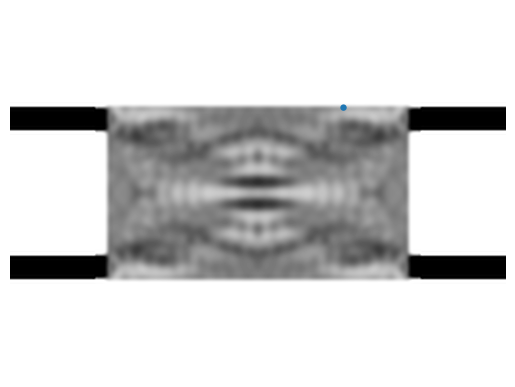

iteration:,  46, eta: 0.5, beta: 16, t: 0.36894, obj. func.: [0.03830875298707732,0.040310010434996435,0.041588300642043365,0.04208180992928527,0.04174238190441377,0.040521511796911144,0.0383888555454416,0.03542585628301355,0.0319247094567025,0.02826465266110657,0.024697471471893107,0.02132377107808632,0.018173779668136356,0.015270829396918015,0.012649280323685005,0.010349715741553816,0.008409432961555285,0.006850210350021205,0.005698784379188379,0.005017412486868619,0.004844082864864812,0.005122363199248159,0.005723139448727064,0.006498381470197599,0.007308617632429822,0.008030093410612879,0.008561669628875621,0.008847253157416548,0.008912551462983191,0.008869519472997035,0.008830324893126183,0.008809317450649407,0.008739929172334657,0.00855332451849056,0.008213685727224685,0.007708506978069831,0.007042834706463068,0.006263354777960779,0.0054670526340339564,0.004762430002542599,0.004234642080275198,0.003935284636641651,0.0038716903427403297,0.004009854548824768,0.004316872702477477,0.

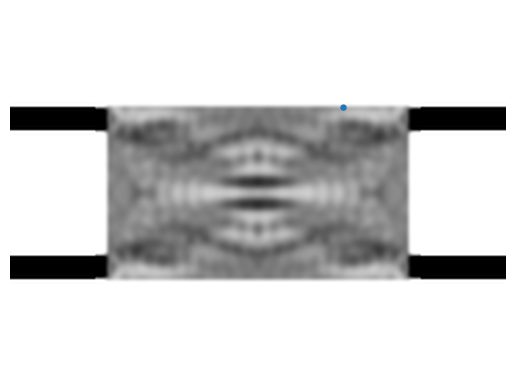

iteration:,  47, eta: 0.5, beta: 16, t: 0.36912, obj. func.: [0.039242692804833335,0.041278168549449226,0.04257474773298974,0.043070045365388276,0.042715357010309894,0.041462225862136555,0.0392816283194883,0.03625790615606821,0.03268723651558358,0.028952681693017155,0.025307410537525218,0.021850971409131423,0.018614048967141254,0.015623254909456737,0.012916791244725348,0.01053732075269924,0.008521975036215278,0.006892800734999026,0.00568006087696581,0.004949707284691034,0.004739992886854292,0.004993105813725153,0.00557909227746801,0.006349603184662228,0.007164732761354802,0.007899806522483259,0.008452193659312638,0.008763875615698212,0.00885839937447338,0.008845255568612332,0.008833710135058234,0.008835421114338287,0.008782158051103377,0.008604345589131568,0.008265720331595902,0.007753472439113417,0.0070735024592940106,0.006275553151170896,0.005460480022120391,0.004739487594105331,0.004199327223862753,0.0038926093083246315,0.0038266491938224877,0.003966217278704835,0.004277095737823023

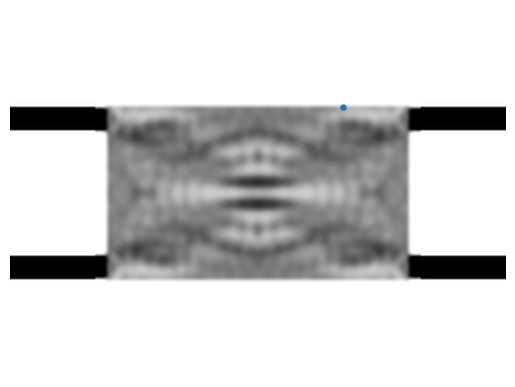

iteration:,  48, eta: 0.5, beta: 16, t: 0.36948, obj. func.: [0.03977991395124447,0.041851638495722605,0.043178024133180885,0.043695708909347056,0.043352904428633654,0.04210021784945327,0.039908812073066395,0.036865571759656025,0.033269564803695105,0.029506080214033312,0.025827491400439165,0.02232787175720118,0.019035992577656296,0.015981051853441463,0.013206435492405917,0.010757010590924394,0.008669353755127986,0.006964576794788698,0.005677971605488206,0.004882813025629222,0.004621406119900766,0.004836352688706701,0.0053975314430661,0.006156278513139132,0.006972219601995937,0.007719581354759349,0.00829401606725566,0.008635546007955516,0.008765565833310424,0.008791191535125972,0.008818078885375037,0.00885405480527216,0.008827794126124245,0.00866775776763284,0.008335986036176997,0.007818133406543156,0.007120332479745455,0.006296147777245258,0.005452058219235919,0.004703472485326522,0.004139365020413643,0.0038136274926107985,0.003733648641575268,0.003863542973619726,0.004168477753601306,

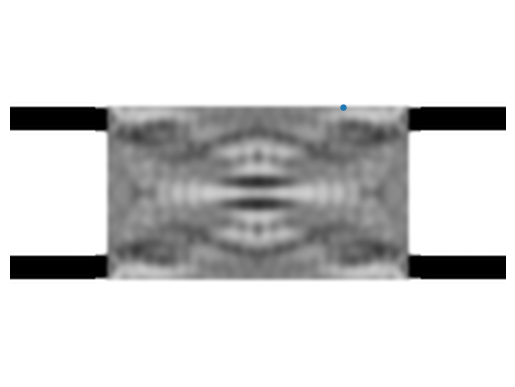

iteration:,  49, eta: 0.5, beta: 16, t: 0.36971, obj. func.: [0.04018758104313353,0.042281826540181824,0.04362640083555705,0.04415703156958972,0.043820948293919325,0.04256770085061642,0.04036953699552336,0.0373144485162909,0.03370313875875026,0.029920194686164525,0.026216177783750606,0.0226819923131063,0.01934648820768388,0.016242010416697008,0.013415516055783672,0.010913792035329056,0.008772983233716865,0.007015172561815652,0.005680009378012356,0.004845163549266794,0.004553154291550824,0.004745563170245875,0.0052919904746994905,0.006044348598321115,0.006862558842211037,0.00762050558724361,0.008212728202541155,0.008577365524598892,0.008733751753907622,0.008786487683851273,0.00883872679457548,0.008895744664897785,0.008884518090582294,0.008732355200779862,0.008400257398966746,0.007873085206774277,0.007157467684076938,0.006310328799769861,0.0054423914484665,0.0046722256489932406,0.004090743939224385,0.003753155086074641,0.00366698786914872,0.003794968924577365,0.0041008261351010355,0.0045

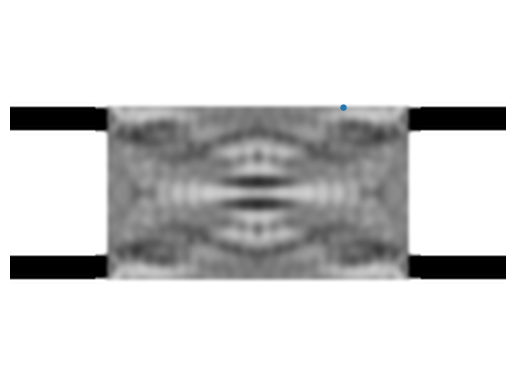

iteration:,  50, eta: 0.5, beta: 16, t: 0.36997, obj. func.: [0.040511476488783574,0.04262569826784763,0.04398739354228859,0.04453150877158,0.04420377807818598,0.04295305409496733,0.04075106155045996,0.037687577851130076,0.03406436621864605,0.030266688536583753,0.026542462589812667,0.02297987773739376,0.01960736942529677,0.01645996633253036,0.01358803384074772,0.011040465137379241,0.008854348307387475,0.007053003669904255,0.0056795842129207874,0.004813922758090472,0.004497974350534036,0.004671977394798205,0.005205557464787028,0.005951254481511795,0.006769577691204959,0.00753431665625655,0.008139131814985046,0.008520800195463921,0.008696937469623973,0.008770691595312446,0.008843453517278266,0.008918696763162056,0.00892155859323789,0.008777918405060725,0.008447637653457366,0.007914678595170454,0.007186248533237,0.006321850330567857,0.005435762795428494,0.004649043517602317,0.004054219909149933,0.0037076509007415897,0.0036171031484597297,0.003744536451088741,0.0040525221041721755,0.004534

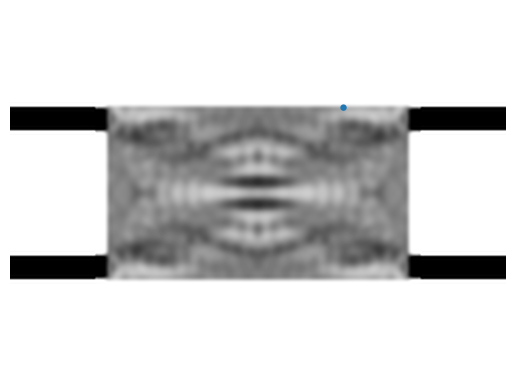

iteration:,  51, eta: 0.5, beta: 16, t: 0.37022, obj. func.: [0.04071189588297437,0.04284634728072367,0.04422880718423938,0.04479213236205439,0.0444810272493943,0.04324232434331472,0.04104779637131367,0.03798804440400707,0.03436589883950464,0.030566453886560905,0.02683442978397919,0.023254627313180464,0.01985436499617923,0.016671703984972242,0.013760050003776322,0.011170776657853055,0.008941130242634826,0.007095773352477333,0.005681304654267462,0.004780946855815406,0.00443685860250429,0.004588786585374148,0.005106531652541504,0.00584351195599934,0.006660789720423134,0.007432101982839688,0.008050297535508065,0.008450681904000891,0.008649197867563,0.008746969654958345,0.008843263221324126,0.008939240248065396,0.00895825426854584,0.008824772810667167,0.008497437963043784,0.007959229477666844,0.007217763286697423,0.006335357685057966,0.005430030468357527,0.004625442654127933,0.004015792596530566,0.0036584719565787944,0.0035615916295619653,0.0036862824631090827,0.003994268804969289,0.004478

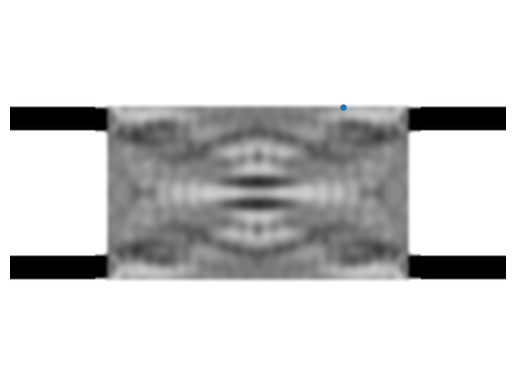

iteration:,  52, eta: 0.5, beta: 16, t: 0.36865, obj. func.: [0.042086810224218195,0.044099406048754286,0.04533785981244263,0.045745854884913485,0.04528095779105593,0.043904301992840115,0.041600903905460875,0.038464059113894854,0.03477820853364603,0.03090147545609593,0.027071253218182,0.023384442186851543,0.019880414172295528,0.016602712634194376,0.013608986092226542,0.010960074815477372,0.008708432544091323,0.006887105926814646,0.005528401644289439,0.004688192541835714,0.0043906176436332095,0.004570934121241259,0.005100802558448969,0.005836858670809514,0.00664355678465716,0.007398267472812558,0.00799792320639865,0.008381577925595043,0.008566937603642454,0.008653240357363295,0.008736157339147689,0.008816362920701131,0.008821531514837591,0.008682847297113319,0.008365731885616607,0.007858048439589007,0.007166128225762709,0.006343149886699288,0.005496625014663245,0.004744006346706534,0.004175280386788504,0.0038446180882629423,0.0037608029503365574,0.003890346997062427,0.004199197877100136

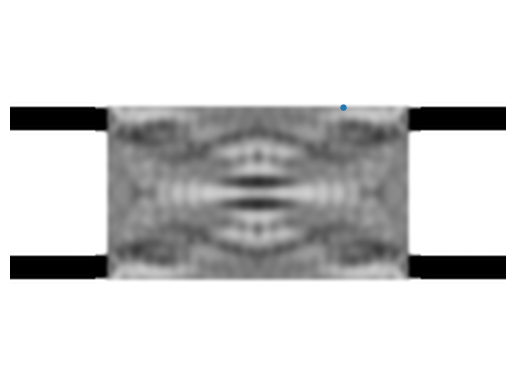

iteration:,  53, eta: 0.5, beta: 16, t: 0.36878, obj. func.: [0.04224552001279881,0.04428696182317181,0.0455494228724354,0.04597505756020286,0.04551994502285031,0.04414365162821208,0.04182987160028478,0.03867260450959204,0.03496109367341543,0.031059903254069744,0.027209323132220933,0.023505632949026592,0.01998713128219048,0.01669692539958598,0.013692176910688468,0.011032315830768288,0.008767481863333287,0.006929554588415044,0.0055531464933756755,0.004698114705670234,0.00439077549273966,0.004566349449963332,0.005095518893397502,0.005833778452991176,0.006644463003609222,0.0074038231532453135,0.008007682428444183,0.008394193165083485,0.008580835372895328,0.008667653234332232,0.008751549642191473,0.00883354236540921,0.00884045773974175,0.00870217841503863,0.008382982729156968,0.007870060766009095,0.00717007515845395,0.006337728899533113,0.0054822044160963155,0.004721978429117876,0.0041477771317054496,0.0038143857424506344,0.0037304676031667014,0.0038615043807688275,0.004172498061354073,0.0

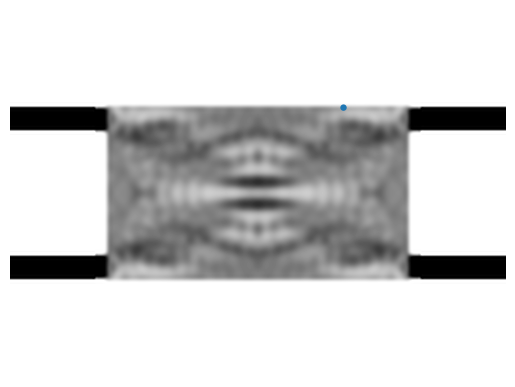

iteration:,  54, eta: 0.5, beta: 16, t: 0.36906, obj. func.: [0.042326334154813246,0.044395099412240444,0.04568162727626602,0.046126666570289174,0.04568478526201624,0.04431402840002107,0.04199655215066718,0.03882640911657339,0.03509658005754518,0.031177404184095127,0.027312192309987764,0.02359702682930708,0.02006947836117747,0.016772231303225173,0.013761791644080283,0.011095814881809322,0.00882175764040806,0.006970091696989268,0.005577775461945275,0.004708763204015323,0.004391694171696522,0.00456198406221401,0.005089628021225839,0.005829308632168298,0.006643552207513659,0.0074078124701276084,0.008017024289640864,0.008408448341287829,0.008598862824521845,0.008688246192753194,0.008774003263605796,0.008857456074626681,0.008865054578084994,0.008725879108596133,0.008403436274199117,0.007884439419845896,0.007176094458445324,0.006334643108348276,0.005470862776890391,0.004704008334302578,0.004125493904436642,0.003790675556377357,0.0037081229026600117,0.0038420884704628666,0.00415643331844874,0

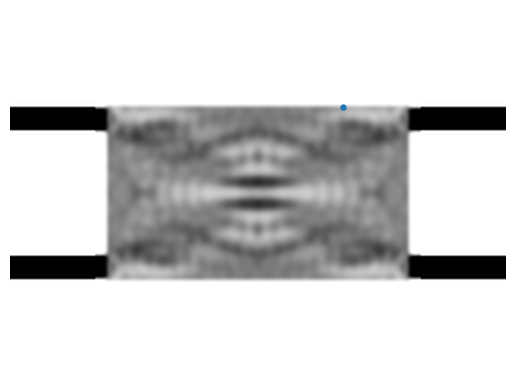

iteration:,  55, eta: 0.5, beta: 16, t: 0.36916, obj. func.: [0.04238316393222045,0.044477916945290415,0.04578789661214686,0.046252335976989634,0.04582427144362247,0.04446004382427121,0.04214023769343091,0.03895900739381421,0.03521324113389093,0.031279006302442604,0.027402281475094475,0.023678530349662618,0.020144266556017382,0.016841666637534107,0.013826639108378936,0.011155319212721596,0.008872795040275085,0.007008368373038903,0.005601250716403574,0.004719261900769963,0.004393217919487478,0.004558685527212801,0.0050849738142148375,0.005825940778636717,0.00664330378109559,0.007411685362418582,0.008025140484715762,0.008420101882464883,0.008612898079666472,0.008703815894325626,0.008791063456936987,0.00887627499820773,0.00888530393662717,0.00874619849865929,0.008421489867171433,0.007897317557450337,0.007181273106549452,0.006331082157271021,0.005459051304601959,0.004685318539931457,0.004101968452488816,0.0037649612829678374,0.0036827677611456027,0.003818614548975929,0.004135387995735163,0

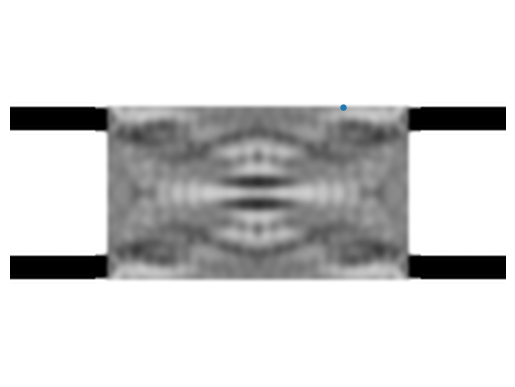

iteration:,  56, eta: 0.5, beta: 16, t: 0.36929, obj. func.: [0.042426265575457395,0.044539736672366985,0.04586617685532004,0.046343925296062835,0.04592518134910008,0.04456533119597426,0.042243825715071646,0.039054489250238175,0.035296384668710386,0.03134956026106015,0.02746242954005738,0.023730898209563023,0.020191268903027807,0.016885397907802337,0.013868458675927071,0.011195119202510283,0.008908493481348543,0.007037126235669996,0.005621999380522082,0.00473351419348543,0.004403598980806681,0.004567628222330327,0.005094329927554153,0.005837056804493505,0.006657076510938584,0.007428574574557266,0.00804505240228845,0.008442313719236995,0.008636137923566364,0.008726858673813107,0.008813365461103772,0.008897840306309253,0.008905907291300957,0.008764946435224408,0.008436836732733996,0.007907439969378944,0.007184792497350251,0.0063277321867934696,0.005449556654093207,0.004670930087750663,0.004084467514562758,0.0037467131588453783,0.0036661808312015514,0.003805196127880741,0.0041255925812035

In [10]:
input_flux, input_flux_data = straight_waveguide()

algorithm = nlopt.LD_MMA

n = Nx * Ny

# initial design parameters
x = np.ones((n,)) * 0.5 #+ np.random.normal(loc=mean, scale=std, size=(n,))
x[Si_mask.flatten()] = 1.0  # set the edges of waveguides to silicon
x[Air_mask.flatten()] = 0.0  # set the other edges to SiO2

# lower and upper bounds for design weights
lb = np.zeros((n,))
lb[Si_mask.flatten()] = 1.0
ub = np.ones((n,))
ub[Air_mask.flatten()] = 0.0

# insert epigraph variable initial value (arbitrary) and bounds into the
# design array. the actual value is determined by the objective and
# constraint functions below.
x = np.insert(x, 0, 1.2)
lb = np.insert(lb, 0, -np.inf)
ub = np.insert(ub, 0, +np.inf)

objfunc_history = []
epivar_history = []
cur_iter = [0]

beta_thresh = 64 # threshold beta above which to use subpixel smoothing
betas = [8, 16, 32, 64, 128, 256]
max_evals = [30, 30, 30, 60, 60, 100]
tol_epi = np.array([1e-4] * 3 * len(frequencies))  # R_top, R_bot, 1-T
tol_lw = np.array([1e-8] *2 )  # line width, line spacing

input_flux, input_flux_data = straight_waveguide()

for beta, max_eval in zip(betas, max_evals):
    solver = nlopt.opt(algorithm, n + 1)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_min_objective(f)
    solver.set_maxeval(max_eval)
    solver.set_param("dual_ftol_rel", 1e-7)
    solver.add_inequality_mconstraint(
        lambda rr, xx, gg: c(
            rr,
            xx,
            gg,
            eta_i,
            beta,
            False if beta < beta_thresh else True,
            
        ),
        tol_epi,
    )


    opt = dc_optimization(
        input_flux, 
        input_flux_data,
        True,  # use_damping
        False if beta < beta_thresh else True,  # use_epsavg
        beta,
    )
    # apply the minimum linewidth constraint
    # only in the final epoch to an initial
    # binary design from the previous epoch.
    if beta == betas[-1]:
        res = np.zeros(2)
        grd = np.zeros((2, n + 1))
        t = glc(res, x, grd, beta)
        solver.add_inequality_mconstraint(
            lambda rr, xx, gg: glc(
                rr,
                xx,
                gg,
                beta,
            ),
            tol_lw,
        )

    # execute a single forward run before the start of each
    # epoch and manually set the initial epigraph variable to
    # slightly larger than the largest value of the objective
    # function over the six wavelengths and the lengthscale
    # constraint (final epoch only).
    t0,_ = opt(
        [
            mapping(
                x[1:],
                eta_i,
                beta if beta < beta_thresh else 0,
            ),
        ],
        need_gradient=False,
    )
    #t0 = np.concatenate((t0[0], t0[1], t0[2]))
    x[0] = np.amax(t0)
    x[0] = 1.05 * (max(x[0], t) if beta == betas[-1] else x[0])

    x[:] = solver.optimize(x)


In [ ]:
#################################################
#SAVE THE design_region (x)
#################################################

np.save("design_dc_minimax_lc2.npy",x[1:])

In [ ]:
plt.matshow(x[1:].reshape(Nx,Ny))

In [ ]:
epivar_history=np.array(epivar_history)
np.save("epivar_history_lc2.npy",epivar_history)
plt.figure()
plt.plot(epivar_history,'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Epivar')
plt.show()


In [ ]:
objfunc_history=np.array(objfunc_history)
np.save("obj_history2.npy",objfunc_history)

plt.figure()
plt.plot(10*np.log10(1-objfunc_history),'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Insertion Loss (dB)')
plt.show()

In [ ]:
lb = 1 - np.min(objfunc_history, axis=1)
ub = 1 - np.max(objfunc_history, axis=1)
mean = 1 - np.mean(objfunc_history, axis=1)

num_iters = lb.size

plt.figure()
plt.fill_between(
    np.arange(1, num_iters + 1), 10 * np.log10(lb), 10 * np.log10(ub), alpha=0.3
)
plt.plot(10 * np.log10(mean), "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("Average Insertion Loss (dB)")
plt.show()

In [ ]:

src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center1)]



sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=mp.air,
                    resolution=resolution)



mode = 1

TE0 = mpa.EigenmodeCoefficient(sim,
        mp.Volume(center=mp.Vector3(x=-(Sx/2 - pml_size - 0.4), y=arm_separation/2),
            size=mp.Vector3(y=2)),mode)
TE_top = mpa.EigenmodeCoefficient(sim,
        mp.Volume(center=mp.Vector3(-(-Sx/2 + pml_size + 0.4),arm_separation/2,0),
            size=mp.Vector3(y=arm_separation/2)),mode)
TE_bottom = mpa.EigenmodeCoefficient(sim,
        mp.Volume(center=mp.Vector3(-(-Sx/2 + pml_size + 0.4),-arm_separation/2,0),
            size=mp.Vector3(y=arm_separation/2)),mode)
ob_list = [TE0,TE_top,TE_bottom]

def J(output,top_source,bottom_source):
    power = npa.abs(output) ** 2 / (npa.abs(top_source)**2 + npa.abs(bottom_source)**2) #npa.abs(output/top_source) ** 2 + npa.abs(output/bottom_source) ** 2 
    return 1-power#npa.mean(power)

opt = mpa.OptimizationProblem(
    simulation = sim,
    objective_functions = J,
    objective_arguments = ob_list,
    design_regions = [design_region],
    frequencies=frequencies
)
opt.plot2D(True)

In [ ]:
cur_beta=256
f0, dJ_du = opt([mapping(x[1:],eta_i,cur_beta)],need_gradient = False)
frequencies = opt.frequencies
source_coef, top_coef, bottom_ceof = opt.get_objective_arguments()

top_profile = np.abs(top_coef/source_coef) ** 2
bottom_profile = np.abs(bottom_ceof/source_coef) ** 2


In [ ]:
plt.figure()
plt.plot(1/frequencies,top_profile*100,'-o' ,label = 'Top Arm')
plt.plot(1/frequencies,bottom_profile*100,'--o',label = 'Bottom Arm')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Power Splitting Ratio (%)')
#plt.ylim(46.5,50)
plt.show()

In [ ]:
plt.figure()
plt.plot(1/frequencies,1-(np.abs(top_coef) ** 2 + np.abs(bottom_ceof) ** 2)/np.abs(source_coef) ** 2,'-o' ,label = 'Insertion loss')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Insertion loss')
#plt.ylim(46.5,50)
plt.show()

In [ ]:
plt.figure()
plt.plot(1/frequencies,(np.abs(top_coef) ** 2 / np.abs(bottom_ceof) ** 2) ** 2,'-o' ,label = 'Output ration')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Output power ration')
#plt.ylim(46.5,50)
plt.show()

In [ ]:
src = mp.ContinuousSource(frequency=1 / 1.55, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center1,
    )
]
opt.sim.change_sources(source)
opt.sim.run(until=500)
opt.sim.plot2D(fields=mp.Ez)

In [ ]:
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=mp.air,
                    resolution=resolution)

In [ ]:
plt.figure(dpi=100)
sim.plot2D()
plt.show()

In [ ]:
sim.run(until=300)


In [ ]:
plt.figure(dpi=120)
sim.plot2D(fields=mp.Ez)
plt.show()

In [ ]:
sim.reset_meep()
f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
plt.close()

In [ ]:
sim.run(mp.at_every(1, Animate), until=150)
plt.close()

In [ ]:
filename = "dc_2d_15x4_1s.mp4"
Animate.to_mp4(10, filename)

In [ ]:
Video(filename)


In [ ]:
src = mp.ContinuousSource(frequency=1 / 1.55, fwidth=fwidth)
sources = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center1,
                    amplitude=1.0),
            mp.EigenModeSource(
                    src,
                    eig_band=1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size=source_size,
                    center=source_center2,
                    amplitude=0.0 - 1.0j
    )]

In [ ]:
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=mp.air,
                    resolution=resolution)

plt.figure(dpi=100)
sim.plot2D()
plt.show()

In [ ]:
sim.run(until=300)


In [ ]:
plt.figure(dpi=120)
sim.plot2D(fields=mp.Ez)
plt.show()

In [ ]:
sim.reset_meep()
f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
plt.close()

In [ ]:
sim.run(mp.at_every(1, Animate), until=300)
plt.close()

In [ ]:
filename = "dc_2d_15x4_2s.mp4"
Animate.to_mp4(10, filename)

In [ ]:
Video(filename)
